# ANNALISA 

**Advanced Non-linear transient-Noise Analysis of Laser Intererometer Sensor Arrays**

## Imports

In [1]:
import h5py as h5
import os
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
import numpy as np
import matplotlib.mlab as mlab
from scipy.interpolate import interp1d
from matplotlib.cm import get_cmap

In [2]:
try:
    from gwpy.timeseries import TimeSeries
except ModuleNotFoundError:
    !pip install --quiet gwpy
    from gwpy.timeseries import TimeSeries
from gwpy.frequencyseries import FrequencySeries
from gwpy.signal import filter_design
from scipy.signal import find_peaks
import time
from tqdm import tqdm
import json
import torch
import multiprocessing
import math
import csv
import time

## Helper Functions

In this section we define some low level functions for data loading, preprocessing, computing of qtransform and peak frequency comparison, as well as plotting of histograms and qtransforms.

In [3]:
def construct_dataframe(path,channel_list=None ,target_channel='V1:Hrec_hoft_16384Hz',n1_events=None, n2_events=None,n1_channels=None,n2_channels=None,print_=False):
    if not n1_events:
        n1_events=0
    if not n2_events:
        n2_events=len(listdir(path))
        
    if n2_events>len(listdir(path)):
        n2_events=len(listdir(path))
    
    #print(f'PATH: {path}')    
    lstdr=listdir(path)[n1_events:n2_events]
    sample_file=listdir(path)[0]
    
    files = [f for f in lstdr]
    # print(files)
    df_list = []
    event_data = []
    
    
    if not channel_list:
        n_all_channels=0
        all_channels=[]
        with h5.File(os.path.join(path, sample_file), 'r') as fout:
            event_id = list(fout.keys())[0]
            all_channels=list(fout[event_id])
            n_all_channels=len(list(fout[event_id]))
            #print(f'event id: {event_id}')


        if not n1_channels:
            n1_channels=0
        if not n2_channels:
            n2_channels=n_all_channels

        if n2_channels>n_all_channels:
            n2_channels=n_all_channels

        channels=all_channels[n1_channels:n2_channels]
    else:
        channels=channel_list
    try:
        channels.remove(target_channel)
    except:
        pass
    
    
    for i, file in enumerate(files):
        if print_:
            print(f"Added {i + 1}/{n2_events - n1_events} files to dataframe", end='\r')
       
           
        try:
            
            with h5.File(os.path.join(path, file), 'r') as fout:
                #print('file successfully opened')
                event_id = list(fout.keys())[0]
                dictionary = {'Event ID': event_id}
                #dictionary={}
                event_data.append(event_id)
                
                
                tmsrs = TimeSeries(fout[event_id][target_channel],dt=1.0/fout[event_id][target_channel].attrs['sample_rate']) #ToDo: add other attrs to the TimeSeries (seee h5_gwpy.ipynb for reference)
                dictionary[target_channel] = [tmsrs]
                #print(f'DICT: {dictionary}')
                
                for i,channel in enumerate(channels):
                    #print(f"Added {i + 1}/{n2_channels - n1_channels} files to dataframe", end='\r')
                    
                    tmsrs = TimeSeries(fout[event_id][channel],dt=1.0/fout[event_id][channel].attrs['sample_rate'])
                    dictionary[channel] = [tmsrs]
                        
                
                df_list.append(pd.DataFrame(dictionary))
                    

                
        except Exception as e:
        
            if print_:
                print(f'COULD NOT OPEN {os.path.join(path, file)}')
                print(e)
            
        
        
    #print(f'DF LIST: {df_list.shape}')
    
    df = pd.concat(df_list, ignore_index=True)
    
    #df_ids = pd.DataFrame({'Event ID': event_data})
    #df = pd.concat([df_ids, df], axis=1)
    
    return df 

In [7]:
def cut_df(df, n1_row,n2_row,n1_col=0,n2_col=None):#,target_channel='V1:Hrec_hoft_16384Hz'
    
    if n2_col==None:
        n2_col=len(list(df.columns))
    if n2_row>df.shape[0]:
        n2_row=df.shape[0]

    if n2_col>len(list(df.columns)):
        n2_col=len(list(df.columns))
    temp_df=df.iloc[n1_row:n2_row,n1_col:n2_col]
    
    #if not target_channel in list(df.iloc[n1_row:n2_row,n1_col:n2_col].columns):
        #temp_df.insert(0, target_channel, df.loc[n1_row:n2_row,target_channel])
    return temp_df
    

In [8]:
def construct_dataset(path, n1_events=None, n2_events=None,save_name=None,channels=None):
    if not n1_events:
        n1_events=0
    if not n2_events:
        n2_events=len(listdir(path))
    lstdr=listdir(path)[n1_events:n2_events]
    
    
    files = [f for f in lstdr]
    df_list = []
    event_data = []
    
    for i, file in enumerate(files):
        print(f"Added {i + 1}/{n2_events - n1_events} files to dataframe", end='\r')
       
        if channels:
            try:
                    with h5.File(os.path.join(path, file), 'r') as fout:
                        event_id = list(fout.keys())[0]
                        dictionary={}
                        #dictionary = {'Event ID': event_id}
                        #event_data.append(event_id)

                        for channel in channels:
                            tmsrs = TimeSeries(fout[event_id][channel])
                            tensor_data = torch.tensor(tmsrs.value)
                            dictionary[channel] = [tensor_data]

                        df_list.append(pd.DataFrame(dictionary))
            except Exception as e:
                print(f'COULD NOT OPEN {os.path.join(path, file)}')
                print(e)
        
        
        else: 
            try:
                with h5.File(os.path.join(path, file), 'r') as fout:
                    event_id = list(fout.keys())[0]
                    dictionary = {'Event ID': event_id}
                    event_data.append(event_id)

                    for channel in list(fout[event_id]):
                        tmsrs = TimeSeries(fout[event_id][channel])
                        tensor_data = torch.tensor(tmsrs.value)
                        dictionary[channel] = [tensor_data]

                    df_list.append(pd.DataFrame(dictionary))
            except Exception as e:
                print(f'COULD NOT OPEN {os.path.join(path, file)}')
                print(e)
    
    df = pd.concat(df_list, ignore_index=True)
    #df_ids = pd.DataFrame({'Event ID': event_data})
    #df = pd.concat([df_ids, df], axis=1)
    if not save_name:
        save_name=f'Dataset {n1_events}_{n2_events}'
        
    df.to_pickle(f'{save_name}.pkl')
    return df

In [98]:
def dummy_qt(t):
    duration = len(t.value)*t.dt.value  # seconds
    dt = t.dt.value  # Hz
    # Create a time array
    times = np.arange(0, duration, dt)

    sine_wave = np.sin(2 * np.pi * times)
    t=TimeSeries(sine_wave, dt=dt)
    hq=t.q_transform()
    hq=hq-hq
    return hq

In [100]:
def process_entry(t,f_range):
    #t.dt = 1.0 / 4096.0 #uncomment when dealing with .h5 files!
    if np.max(t) == np.min(t):
        return dummy_qt(t)
    else:
        #t = t.whiten() shouldn't be needed as whiten is included in q_transform.Also, it produces errors when t is NaN (it can happen for borken raw .gwf files)
        try:
            max_value = t.value.max()       #Normalizing the tseries speeds up the asd and doesn't change the qplot. It also avoids FLoatingPOintErrors (arising from Underflow)
            scaled_data = t / max_value
            qt=scaled_data.q_transform()
            if np.isnan(qt.value).any():
                print('Encountered nan values in q_transform')
                return dummy_qt(t)
            else:
                return qt
            #return t.q_transform(frange=f_range)
        
        except:
            print('returning dummy qt')
            return dummy_qt(t)


def reshape_list(flat_list, num_rows, num_columns):
    # Reshape a flat list into a list of lists with specified dimensions
    return [flat_list[i:i + num_columns] for i in range(0, len(flat_list), num_columns)]


def process_data_for_qplot_vectorised_multiprocess(df,n1_events=None,n2_events=None,freq_window=(10,2048),processes=None,save=False):
    
    f_min=freq_window[0]
    f_max=freq_window[1]

        
    # Number of processes to run in parallel
    num_processes_max = multiprocessing.cpu_count()
    #print(f'Number of processes max:{num_processes_max}')
    if num_processes_max<processes:
        num_processes=num_processes_max
    else:
        num_processes=processes
        
    #id_col=df['Event ID']
    try:
        df.drop('Event ID', axis=1, inplace=True)
    except:
        pass
    row,col=df.shape
    columns=list(df.columns)
    df_list=df.values.flatten().tolist()
    args_flatten=[(entry,freq_window) for entry in df_list]
    
    with multiprocessing.Pool(num_processes) as pool:
        results=list(tqdm(pool.starmap(process_entry,args_flatten),total=len(args_flatten)))
        
    ordered_results = reshape_list(results, row, col)   
    df_freq=pd.DataFrame(columns=columns, data=ordered_results)
    if save:
        df_freq.to_pickle(f'Q-Transforms{n1_events}_{n2_events}.pkl')
    #hq_list=df_freq.T.values.tolist() # ToDo: instead of taking the transpose, change the for loop in cf, stupid
    return df_freq #hq_list


In [97]:
def scatter_plot_peaks_2d(qt,strain_peaks=None,all_channel_label=None,aux_peaks_list=None):
    cmap='viridis'
    fig, ax = plt.subplots()

    img=ax.imshow(qt,cmap=cmap,vmin=0,vmax=25,aspect='auto',origin='lower')

    #ax.colorbar()
    fig.colorbar(img, ax=ax)
    if strain_peaks:        
    
        x_values = [point[0] for point in strain_peaks]
        y_values = [point[1] for point in strain_peaks]

        #if qt:
        #    qt.plot()

        # Get the tab10 colormap
        #cmap = get_cmap('tab10')

        # Create a scatter plot for main channel
        ax.scatter(x_values, y_values, marker='x',label='strain', color='red')
    
    
    #create a scatter plot for aux channels
    if aux_peaks_list:
        #colors=['b','y','g']
        colors = plt.cm.rainbow(np.linspace(0, 1, len(aux_peaks_list)))
        for aux_peaks in aux_peaks_list:
            x_values = [point[0] for point in aux_peaks]
            y_values = [point[1] for point in aux_peaks]

            # Get a color from the tab10 colormap for each sublist
            #color = cmap(i % 3)
            idx=aux_peaks_list.index(aux_peaks)
            color=colors[idx]
            if all_channel_label:
                ax.scatter(x_values, y_values, color=color, alpha=1, marker='+',label=all_channel_label[idx])
                #ax.scatter(x_values, y_values, alpha=1, marker='+')
                           #,label=all_channel_label[idx])
                #ax.scatter(x_values, y_values, alpha=1, marker='+')

            else:
                #ax.scatter(x_values, y_values, color=color, alpha=1, marker='+',label=idx)
                ax.scatter(x_values, y_values, alpha=1, marker='+')
                           #,label=idx)

    # Set labels for the axes
  
    ax.set_xscale('seconds')
    ax.set_ylim(10, 128)
    ax.set_xlim(6, 10)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Frequency [Hz]')
    ax.legend()
    ax.set_yscale('log', base=2)
    #fig.show()
    return fig, ax

In [102]:
def compare_2d_peaks(peaks_1, peaks_2,t_window_peaks=None,time_only_mode=False,tolerance_distance=0):
    
    peaks_1_cut=[(t[0],t[1]) for t in peaks_1]
    peaks_2_cut=[(t[0],t[1]) for t in peaks_2]
    if t_window_peaks:
        peaks_2_cut = [tup for tup in peaks_2_cut if t_window_peaks[0] <= tup[0] <= t_window_peaks[1]]
        
    common_peaks=[]
    for peak in peaks_1_cut:
        if time_only_mode:
            dists=[np.linalg.norm(np.array(peak[0])- np.array(p[0])) for p in peaks_2_cut]
        else:
            dists=[np.linalg.norm(np.array(peak)- np.array(p)) for p in peaks_2_cut]
        if np.sum(np.array(dists)<=tolerance_distance)>0:
            common_peaks.append(peak)
    return common_peaks

In [13]:
def peaks_from_qt(qtransform, threshold=25):
    # Extract time, frequency, and magnitude values from the Q-transform
    try:
        times = qtransform.times.value
        frequencies = qtransform.frequencies.value
        magnitudes = np.abs(qtransform.value)
    except:
        print(qtransform)
        raise Exception
            

    # Find peaks in the flattened magnitude values
    peaks, _ = find_peaks(magnitudes.flatten(), height=threshold)

    # Convert flattened indices to 2D indices
    peaks_2d = np.unravel_index(peaks, magnitudes.shape)

    # Create a list of tuples containing (time, frequency, magnitude) coordinates of each peak
    peak_coordinates = [(times[peaks_2d[0][i]], frequencies[peaks_2d[1][i]], magnitudes[peaks_2d[0][i], peaks_2d[1][i]]) for i in range(len(peaks))]
    return peak_coordinates

In [14]:
def plot_histogram(ax,avs,all_channels,n_start, n_stop):

    ax.bar(range(len(avs)),avs, tick_label=all_channels)
    
    ax.set_xticklabels(all_channels, rotation=90)

    ax.set_title('Average of Common Frequencies')

    #plt.tight_layout()
    hist_path='/home/jovyan/Correlation_Among_'+str(n_start)+'-'+str(n_stop)+'_Channels.png'
    print(f"The histogram has been saved to {hist_path}")

    plt.savefig(hist_path)
    return

In [101]:
def compare_qt_freqs_rows(row,strain_channel,aux_channels,threshold,plot=False,t_window_peaks=None,time_only_mode=False,tolerance_distance=0):
    #print(row)
    #print(row.shape)
    #print(type(row))
    row_res=row[aux_channels].apply(lambda t: compare_qt_freqs_vectorised(row[strain_channel],t,threshold,plot=plot,t_window_peaks=t_window_peaks,time_only_mode=time_only_mode,tolerance_distance=tolerance_distance))
    
    row_cf = row_res.apply(lambda x: x[0])
    #print(f'ROW CF: {row_cf}')
    #we only plot the 3 auxiliary channels with the highest correlation with the strain
    channel_labels=list(row_cf.nlargest(3).keys())
    peaks_strain=row_res.apply(lambda x: x[1])[channel_labels[0]]
    peaks_aux_list=[row_res.apply(lambda x: x[2])[channel] for channel in channel_labels]
    
    
    if plot:
        fig, ax=scatter_plot_peaks_2d(row[strain_channel],strain_peaks=peaks_strain,aux_peaks_list=peaks_aux_list,all_channel_label=channel_labels)
    
    
    return row_cf
    


def compare_qt_freqs_vectorised(qt_strain,qt_aux,threshold, plot=False,t_window_peaks=None,time_only_mode=False,tolerance_distance=0):
    
    peaks_strain=peaks_from_qt(qt_strain, threshold)
    
    peaks_aux=peaks_from_qt(qt_aux,threshold)
    
    if len(peaks_strain)>0:
        common_peaks=len(compare_2d_peaks(peaks_strain,peaks_aux,t_window_peaks=t_window_peaks,time_only_mode=time_only_mode,tolerance_distance=tolerance_distance))/len(peaks_strain)  
    else:
        common_peaks=0

    return common_peaks,peaks_strain, peaks_aux

## Main Functions

In this section we define high level functions for dataset scanning to compute correlations

In [115]:
import os
import h5py as h5
import numpy as np
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

# Import your other necessary modules and functions (e.g., TimeSeries, dummy_qt)

def scan_dataset(path,chunk_events=None,channel_list=None,chunk_channels=None,n1_events=0,n2_events=None,target_channel='V1:Hrec_hoft_16384Hz',freq_window=(10,2048),threshold=20,plot=False,save_qplot=False,out_path='Correlation_histogram.csv',max_row=None,print_=False,load_whole_df=False,time_only_mode=False,num_processes=20,time_window=None,tolerance_distance=0):
    
    
    #start clock to monitor time
    start_time = time.time()

    #load dataframe
    df = construct_dataframe(path,target_channel=target_channel, n1_events=n1_events, n2_events=n2_events,channel_list=channel_list)
    end_time = time.time()
    df_time = end_time - start_time
    print('\n')
    print(f'DF Loaded in {df_time} s')
    
    
    # Separate target channel from aux_channels
    try:
        df.drop('Event ID', axis=1, inplace=True)
    except:
        pass
    
    target_column=df.pop(target_channel)
    df_target=pd.DataFrame({target_channel:target_column})
    print('Computing target_channel Q-transform...')
    df_target_qtrans=process_data_for_qplot_vectorised_multiprocess(df_target,freq_window=freq_window,processes=num_processes)
    print('done!')
    
    # determine row (event) chunksize
    if n2_events:
        max_row=n2_events-n1_events
    sample_file=listdir(path)[0]
    if (max_row) and (max_row<len(listdir(path))):
        iter_row=math.ceil(max_row/chunk_events)
    else: 
        iter_row=math.ceil(len(listdir(path))/chunk_events)
    
    #determine column (channel) chunksize
    if not channel_list:
        n_all_channels=len(list(df.columns))
        #with h5.File(os.path.join(path, sample_file), 'r') as fout:
            #event_id = list(fout.keys())[0]
            #n_all_channels=len(list(fout[event_id]))
    else:
        n_all_channels=len(channel_list)
    
    if chunk_channels:
        iter_col=math.ceil(n_all_channels/chunk_channels)
    else:
        iter_col=1
        chunk_channels=n_all_channels
    
    
    correlation_avs=np.array([])
    
    
    
    #Compute target channel Qtransform in advance so to not have to do it multiple times in analyse_chunk

    all_in_one=False
    #call recursively the function analyse_chunk to process the dataset in chunks
    for i in tqdm(range(iter_row)):
        corr_avs_row=np.array([]) 
        for j in range(iter_col):
            #with io.capture_output() as captured:
            df_cut=cut_df(df,i*chunk_events,(i+1)*chunk_events,j*chunk_channels,(j+1)*chunk_channels)
            df_target_qt_cut=cut_df(df_target_qtrans,i*chunk_events,(i+1)*chunk_events)
            _,__,___,res=analyse_chunk(df_cut,df_target_qt_cut,time_only_mode=time_only_mode,target_channel=target_channel,freq_window=freq_window,threshold=threshold,time_window=time_window,num_processes=num_processes,tolerance_distance=tolerance_distance)

            corr_avs_row=np.concatenate((corr_avs_row, res))
        try:
            correlation_avs=np.vstack((correlation_avs, corr_avs_row))

        except:
            correlation_avs=corr_avs_row
            all_in_one=True
    
    mean=0
    if not all_in_one:
        mean=np.mean(correlation_avs,axis=0)
    else:
        mean=correlation_avs
     
    aux_channels = list(df.columns)
    correlation_coeff = list(zip(aux_channels, mean))

    print(f'MEAN of correlation coefficient: {correlation_coeff}')      
    avs=correlation_avs
    try:
        np.savetxt(out_path, mean, delimiter=',')
    except:
        print('could not save avs')
     
    

    
    #plt.bar(range(len(avs)), avs, tick_label=aux_channels)
    plt.bar(range(len(mean)), mean, tick_label=aux_channels)

    plt.title('Average of Common Frequencies')
    plt.xticks(rotation=90)

    plt.tight_layout()
    hist_path = f'/home/jovyan/Correlation_Among_{n1_events}-{n2_events}_Channels_vectorised.png'
    plt.savefig(hist_path)
    plt.show()
    print(f"The histogram has been saved to {hist_path}")
    final_t=time.time()
    print(f'TOTAL TIME: {final_t-start_time}s')
    return avs,mean


def analyse_chunk(df_aux,df_target_qt,time_only_mode=False,target_channel='V1:Hrec_hoft_16384Hz',freq_window=(10,2048),threshold=20,time_window=None,num_processes=20,chunk_size=10,plot=False,tolerance_distance=0):
    start_time_qt = time.time()
    df_target_qt=df_target_qt.reset_index(drop=True) #reset index for concatenation
    df_aux_qt =process_data_for_qplot_vectorised_multiprocess(df_aux,freq_window=freq_window,processes=num_processes)
    
    end_time_qt = time.time()
    qt_time = end_time_qt - start_time_qt

    print(f'Q-Transform computed in {qt_time} s')

    aux_channels = list(df_aux.columns)
    #print(f'AUX_CHANNELS: {aux_channels}')
    start_t_cf = time.time()

    tqdm.pandas(desc="Applying compare_qt_freqs")

          
    df_qt = pd.concat([df_target_qt, df_aux_qt], axis=1)
        
    # Define a function to apply compare_qt_freqs_rows in parallel
    def apply_compare_qt_freqs_rows_parallel(row):
        #print(f'row is a {type(row)}')
        return compare_qt_freqs_rows(row[1],target_channel, aux_channels, threshold, plot,time_window,time_only_mode,tolerance_distance)
        
    
   
    #df_qt.values # we had this in the following as argument of apply_compare_qt_freqs_rows_parallel, but it didn0t work because the thing passed was a np array, not a df row
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(apply_compare_qt_freqs_rows_parallel, df_qt.iterrows()))
    
    #Convert to df
    df_cf=pd.DataFrame(results)
    
    end_t_cf = time.time()
    cf_time = end_t_cf - start_t_cf
    print(f'Frequency compared in {cf_time} s')

    # Calculate the mean along each column
    mean_values = df_cf.mean()

    # Calculate the standard deviation along each column
    std_values = df_cf.std()

    # Store the results in NumPy arrays
    avs = mean_values.to_numpy()
    std_array = std_values.to_numpy()
    
        

    end_time = time.time()
    total_time = end_time - start_time_qt
    print(f'Analyse Chunk TIME: {total_time}')
    del df_qt

    return qt_time, cf_time, total_time, avs




## Channel Scan

Example of dataset scanning

In [104]:
path='/data/datasets/intertwin-dati-aux/gspy_O3a_Scattered_Light_V1'



DF Loaded in 8.068743228912354 s
Computing target_channel Q-transform...


100%|██████████| 10/10 [00:00<00:00, 150333.48it/s]


done!


100%|██████████| 160/160 [00:00<00:00, 1874549.27it/s]


Q-Transform computed in 31.515887022018433 s


100%|██████████| 1/1 [01:19<00:00, 79.67s/it]

Frequency compared in 48.148276805877686 s
Analyse Chunk TIME: 79.66490054130554
MEAN of correlation coefficient: [('V1:ENV_METEO_WIND_DIR', 0.06864092408182465), ('V1:ENV_METEO_WIND_SPD', 0.04790506234857066), ('V1:ENV_NEB_SEIS_N', 0.08343990049743646), ('V1:ENV_NEB_SEIS_V', 0.08837494587963632), ('V1:ENV_NEB_SEIS_W', 0.08286910088035791), ('V1:INJ_IMC_TRA_DC', 0.04908521326204253), ('V1:LSC_DARM_ERR', 0.6305796058565646), ('V1:LSC_MICH_ERR', 0.6483042605809067), ('V1:LSC_NE_CORR', 0.3351849667559281), ('V1:LSC_PRCL_ERR', 0.7679803765783844), ('V1:LSC_PR_CORR', 0.7189842113131222), ('V1:Sa_NE_F0_LVDT_V_500Hz', 0.001183431952662722), ('V1:Sa_NE_F0_TY_500Hz', 0.010482073322102145), ('V1:Sa_NE_F0_X_500Hz', 0.005153068587804583), ('V1:Sa_NE_F0_Z_500Hz', 0.000591715976331361), ('V1:Sc_MC_MIR_Z_CORR', 0.044977630249675285)]


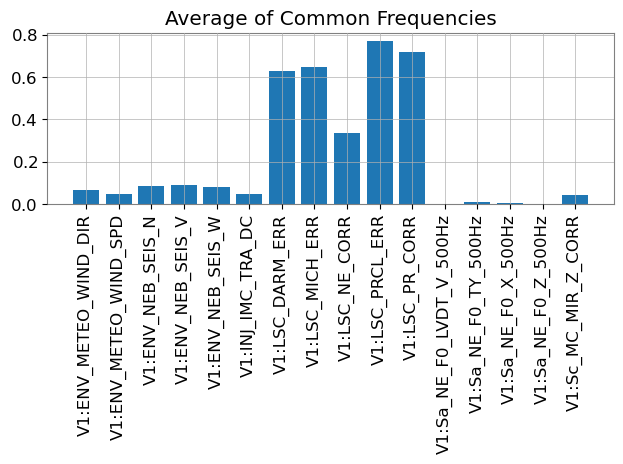

The histogram has been saved to /home/jovyan/Correlation_Among_0-10_Channels_vectorised.png
TOTAL TIME: 99.70555591583252s


In [116]:
avs,mean=scan_dataset(path,chunk_events=10,chunk_channels=18,n2_events=10,max_row=10,time_only_mode=True,freq_window=(10,200),tolerance_distance=0)



DF Loaded in 8.034585237503052 s
Computing target_channel Q-transform...


100%|██████████| 10/10 [00:00<00:00, 176231.26it/s]


done!


100%|██████████| 80/80 [00:00<00:00, 1224614.31it/s]


Q-Transform computed in 22.622477769851685 s


 50%|█████     | 1/2 [00:44<00:44, 44.84s/it]

Frequency compared in 22.213420867919922 s
Analyse Chunk TIME: 44.83659243583679



100%|██████████| 80/80 [00:00<00:00, 1103764.21it/s]


Q-Transform computed in 22.946714878082275 s


100%|██████████| 2/2 [01:32<00:00, 46.34s/it]

Frequency compared in 24.883899927139282 s
Analyse Chunk TIME: 47.83128476142883
 MEAN [0.12752485 0.13234184 0.09634756 0.08959446 0.0828691
 0.12493634 0.73423407 0.78344481 0.53410903 0.90820362
 0.84101334 0.01425232 0.03099016 0.04592341 0.00769231
 0.05218646]


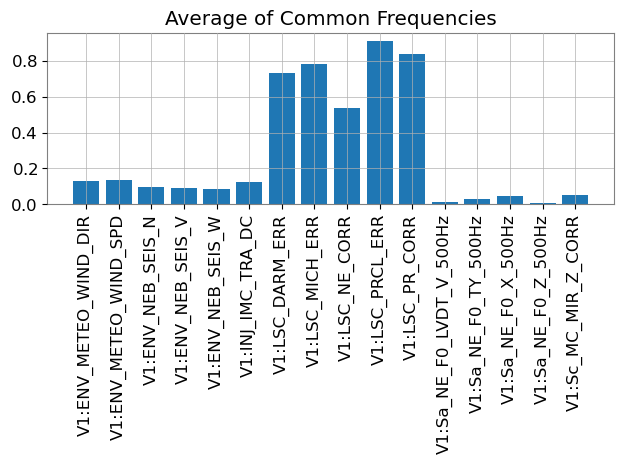

The histogram has been saved to /home/jovyan/Correlation_Among_0-10_Channels_vectorised.png
TOTAL TIME: 116.46352124214172s


In [110]:
avs,mean=scan_dataset(path,chunk_events=5,chunk_channels=18,n2_events=10,max_row=10,time_only_mode=True,freq_window=(10,200),tolerance_distance=0.1)

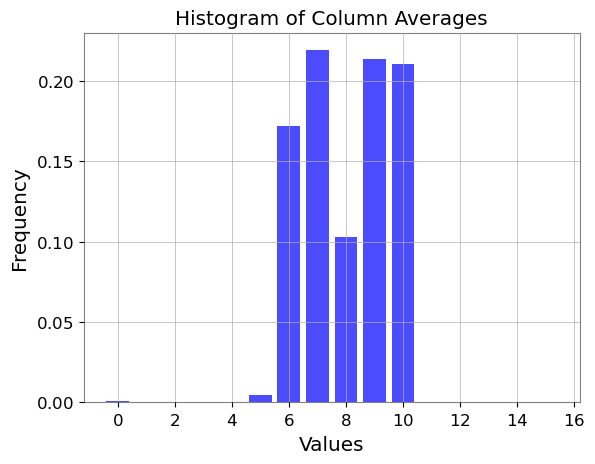

In [319]:
bins = np.arange(len(mean_prova))

# Plot the histogram using plt.bar
plt.bar(bins, mean_prova, color='blue', alpha=0.7)
plt.title('Histogram of Column Averages')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [10]:
path_raw='/data/datasets/intertwin-dati-aux/gspy_O3a_Scattered_Light_V1_raw'

In [11]:
from lalframe.utils.frtools import get_channels
from gwpy.timeseries import TimeSeriesDict
import multiprocessing

In [10]:
gwf_list=[file for file in listdir(path_raw) if '.gwf' in file]
print(len(gwf_list))

11


In [8]:
def extract_channels_from_gwf(path):
    
    for file in listdir(path)[:2]:
        filename=file
        #print(filename)
        CH=0
        if '.gwf' in file:
            CH=get_channels(path+'/'+file)


    return CH, filename

In [12]:
CH,filename=extract_channels_from_gwf(path_raw)
#print(len(CH))

In [13]:
print(len(CH))
print(CH[:10])

37129
['CAL_HI_CW', 'CAL_HI_DetChar', 'V1:ASC_ASC_COLOR', 'V1:ASC_Acl_CfgChange', 'V1:ASC_Acl_cntLoad', 'V1:ASC_Acl_elapsed_time', 'V1:ASC_Acl_lTmo', 'V1:ASC_Acl_nApply', 'V1:ASC_Acl_nLoadApply', 'V1:ASC_Acl_nLoadOnly']


In [229]:
def save_channel_list(path,CH,name):
    with open(path+'/'+name,'w') as file:
    # Write each item in the list to a new line in the file
        for item in CH:
            file.write(f"{item}\n")
    print(f'Channles list successfully saved')

### Vanilla for loop dataframe

In [8]:
def construct_dataframe_from_gwf(path, channels, n1_events=None, n2_events=None):
    if not n1_events:
        n1_events = 1  # first file in the folder is called Fr and is not useful
    if not n2_events:
        n2_events = len(listdir(path))

    df_list = []
    file_list = tqdm(listdir(path)[n1_events:n2_events], desc="Processing files")

    for file in file_list:
        file_list.set_postfix(file=file)
        print(file)
        dictionary = {'GPS time': file.split('-')[2]}

        for i, channel in enumerate(channels):
            print(f"Processed {i + 1}/{len(channels)} channels for {file}", end='\r')

            try:
                tmsrs = TimeSeries.read(path + '/' + file, channel)
                dictionary[channel] = [tmsrs]
            except Exception as e:
                # Handle the exception, e.g., print an error message
                print(f"Error processing {channel} for {file}: {e}")

        df_list.append(pd.DataFrame(dictionary))

    file_list.close()
    df = pd.concat(df_list, ignore_index=True)
    return df

In [136]:
start_time=time.time()
prova_dict=construct_dataframe_from_gwf(path_raw,CH[:37])
end_time=time.time()
print(f'DF constructed in {end_time-start_time} s')

Processing files:   0%|          | 0/11 [00:00<?, ?it/s, file=V-raw-1238505700-100.gwf]

V-raw-1238505700-100.gwf


Processing files:   9%|▉         | 1/11 [00:06<01:02,  6.26s/it, file=V-raw-1244841600-100.gwf]

V-raw-1244841600-100.gwf


Processing files:  18%|█▊        | 2/11 [00:12<00:56,  6.29s/it, file=V-raw-1239691200-100.gwf]

V-raw-1239691200-100.gwf for V-raw-1244841600-100.gwf


Processing files:  27%|██▋       | 3/11 [00:19<00:51,  6.44s/it, file=V-raw-1253675600-100.gwf]XLAL Error - XLALFrameUFrChanRead_FrameL_ (LALFrameL.c:899): Channel CAL_HI_CW not found
XLAL Error - XLALFrameUFrChanRead_FrameL_ (LALFrameL.c:899): Wrong name
XLAL Error - XLALFrFileQueryChanType (LALFrameIO.c:155): Wrong name
XLAL Error - XLALFrameUFrChanRead_FrameL_ (LALFrameL.c:899): Channel CAL_HI_DetChar not found
XLAL Error - XLALFrameUFrChanRead_FrameL_ (LALFrameL.c:899): Wrong name
XLAL Error - XLALFrFileQueryChanType (LALFrameIO.c:155): Wrong name


V-raw-1253675600-100.gwf
Error processing CAL_HI_CW for V-raw-1253675600-100.gwf: channel 'CAL_HI_CW' not found
Error processing CAL_HI_DetChar for V-raw-1253675600-100.gwf: channel 'CAL_HI_DetChar' not found


Processing files:  36%|███▋      | 4/11 [00:25<00:44,  6.33s/it, file=V-raw-1238404200-100.gwf]

V-raw-1238404200-100.gwf for V-raw-1253675600-100.gwf


Processing files:  45%|████▌     | 5/11 [00:31<00:38,  6.39s/it, file=V-raw-1238405200-100.gwf]

V-raw-1238405200-100.gwf for V-raw-1238404200-100.gwf


Processing files:  55%|█████▍    | 6/11 [00:38<00:32,  6.41s/it, file=V-raw-1253675700-100.gwf]XLAL Error - XLALFrameUFrChanRead_FrameL_ (LALFrameL.c:899): Channel CAL_HI_CW not found
XLAL Error - XLALFrameUFrChanRead_FrameL_ (LALFrameL.c:899): Wrong name
XLAL Error - XLALFrFileQueryChanType (LALFrameIO.c:155): Wrong name
XLAL Error - XLALFrameUFrChanRead_FrameL_ (LALFrameL.c:899): Channel CAL_HI_DetChar not found
XLAL Error - XLALFrameUFrChanRead_FrameL_ (LALFrameL.c:899): Wrong name
XLAL Error - XLALFrFileQueryChanType (LALFrameIO.c:155): Wrong name


V-raw-1253675700-100.gwf
Error processing CAL_HI_CW for V-raw-1253675700-100.gwf: channel 'CAL_HI_CW' not found
Error processing CAL_HI_DetChar for V-raw-1253675700-100.gwf: channel 'CAL_HI_DetChar' not found


Processing files:  64%|██████▎   | 7/11 [00:44<00:25,  6.30s/it, file=V-raw-1238406200-100.gwf]

V-raw-1238406200-100.gwf for V-raw-1253675700-100.gwf


Processing files:  73%|███████▎  | 8/11 [00:51<00:19,  6.45s/it, file=V-raw-1240341600-100.gwf]

V-raw-1240341600-100.gwf for V-raw-1238406200-100.gwf


Processing files:  82%|████████▏ | 9/11 [00:57<00:12,  6.48s/it, file=V-raw-1238399300-100.gwf]

V-raw-1238399300-100.gwf


Processing files:  91%|█████████ | 10/11 [01:04<00:06,  6.53s/it, file=V-raw-1238457000-100.gwf]

V-raw-1238457000-100.gwf for V-raw-1238399300-100.gwf


Processing files: 100%|██████████| 11/11 [01:10<00:00,  6.45s/it, file=V-raw-1238457000-100.gwf]

DF constructed in 71.06000518798828 s


### Multiprocess dataframe

In [7]:
def process_entry_gwf(file, path, channel):
    # Process each file and return the TimeSeries
    file_path = f"{path}/{file}"
    try:
        tmsrs = TimeSeries.read(file_path, channel)
    except:
        tmsrs=np.nan
    return tmsrs

def reshape_list(flat_list, num_rows, num_columns):
    # Reshape a flat list into a list of lists with specified dimensions
    return [flat_list[i:i + num_columns] for i in range(0, len(flat_list), num_columns)]

def construct_df_from_gwf_parallel(path,channels,n1_events=None,n2_events=None,processes=37):
    if not n1_events:
        n1_events = 1  # first file in the folder is called Fr and is not useful
    if not n2_events:
        n2_events = len(listdir(path))
        
    # Your input parameters
    file_names = listdir(path)[n1_events:n2_events]
    #file_names = ["file1.hdf5", "file2.hdf5", "file3.hdf5"]

    # Number of processes to run in parallel
    num_processes_max = multiprocessing.cpu_count()
    print(f'Number of processes max:{num_processes_max}')
    
    if num_processes_max<processes:
        num_processes=num_processes_max
    else:
        num_processes=processes
    print(f'using: {num_processes} processes')
    # Create a Pool
    stt=time.time()
    with multiprocessing.Pool(processes=num_processes) as pool:
        # Use starmap to pass multiple arguments to process_file
        results = pool.starmap(process_entry_gwf, [(file, path, channel) for file in file_names for channel in channels])
    ett=time.time()
    print(ett-stt)
    
    # Organize the results into a DataFrame
    stt=time.time()
    ordered_results = reshape_list(results, len(file_names), len(channels))
    ett1=time.time()
    print(f'list reordering: {ett1-stt}')
    df = pd.DataFrame(columns=channels, data=ordered_results)
    ett2=time.time()
    print(f'df from list: {ett2-stt}')
    gps_times=[file.split('-')[2] for file in file_names]
    df['GPS time'] = gps_times  

    # Display or further process the DataFrame
    #print(df)
    return df




In [8]:
times_vs_cores=[]
for i in range(1,2):
    start_time=time.time()
    prova_df=construct_df_from_gwf_parallel(path_raw,CH,processes=i*10)
    end_time=time.time()
    times_vs_cores.append((end_time-start_time,i*10))
    #print(f'DF constructed in {end_time-start_time} s')

Number of processes max:112
using: 10 processes


XLAL Error - XLALFrameUFrChanRead_FrameL_ (LALFrameL.c:899): Channel V1:LSC_DARM_OUT_Arm_control*Arm_integrator*Arm_boost*Arm_boost2 not found
XLAL Error - XLALFrameUFrChanRead_FrameL_ (LALFrameL.c:899): Wrong name
XLAL Error - XLALFrFileReadREAL4TimeSeries_ (LALFrameIO_source.c:61): Wrong name
XLAL Error - XLALFrStreamGetREAL4TimeSeries (LALFrStreamReadTS_source.c:63): Internal function call failed: Wrong name
XLAL Error - XLALFrStreamReadREAL4TimeSeries (LALFrStreamReadTS_source.c:221): Internal function call failed: Wrong name
XLAL Error - XLALFrameUFrChanRead_FrameL_ (LALFrameL.c:899): Channel V1:Daq_EDB_DBOX_DetEEroom_Monitoring_Tolm_Send_Transmit_Max_Ind not found
XLAL Error - XLALFrameUFrChanRead_FrameL_ (LALFrameL.c:899): Wrong name
XLAL Error - XLALFrFileReadREAL4TimeSeries_ (LALFrameIO_source.c:61): Wrong name
XLAL Error - XLALFrStreamGetREAL4TimeSeries (LALFrStreamReadTS_source.c:63): Internal function call failed: Wrong name
XLAL Error - XLALFrStreamReadREAL4TimeSeries (LAL

10379.503422021866
list reordering: 0.011552572250366211
df from list: 0.8315267562866211


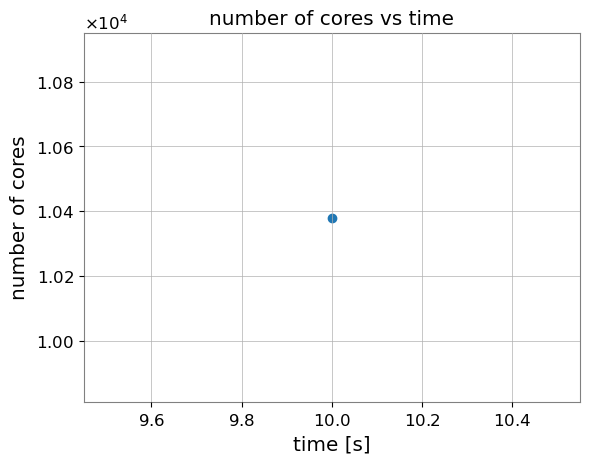

In [9]:
# Unpack the tuples into separate lists for x and y coordinates
y_values, x_values = zip(*times_vs_cores)

# Create a scatter plot
plt.scatter(x_values, y_values)

# Add labels and title
plt.xlabel('time [s]')
plt.ylabel('number of cores')
plt.title('number of cores vs time')

# Show the plot
plt.show()

### Vanilla lalframe dataframe

In [347]:
from lalframe.frread import read_timeseries

def convert_to_gwpy(tagREAL4TimeSeries_object):
    #print('inside')
    time_series_data = tagREAL4TimeSeries_object.data.data
    #print(time_series_data)
    sample_rate = 1/tagREAL4TimeSeries_object.deltaT
    #print(sample_rate,len(time_series_data))
    a=TimeSeries(time_series_data, sample_rate=sample_rate)
    #print(a)
    #print(type(a))
    return a

def construct_dataframe_from_gwf_lal(path, channels, n1_events=None, n2_events=None):
    if not n1_events:
        n1_events = 1  # first file in the folder is called Fr and is not useful
    if not n2_events:
        n2_events = len(listdir(path))

    df_list = []
    file_list = listdir(path)[n1_events:n2_events]
    df=pd.DataFrame()
    
    for file in file_list:
        #dictionary = {'GPS time': file.split('-')[2]}
        #file_list.set_postfix(file=file)
        print(file)
        
        try:
            tmsrs = read_timeseries(path + '/' + file, channels)
            #print('before')
            tmsrs2=list(map(convert_to_gwpy,tmsrs))
            #print(tmsrs2)
            #print(type(tmsrs2[0]))
            #print('after')
            #df_row['GPS time']=file.split('-')[2]
            df_row = pd.DataFrame([tmsrs2], columns=channels)
            df_row['GPS time']=file.split('-')[2]
            #print('No EXCEPT BITCH')
            
        except Exception as eee:
            #print(eee)
            dictionary = {'GPS time': file.split('-')[2]}
            for channel in channels:
                try:
                    tmsrs = TimeSeries.read(path + '/' + file, channel)
                except Exception as e:
                    tmsrs=np.nan
                    print(f'Error in {file} {channel}: {e}')
                dictionary[channel] = [tmsrs]
                
            df_row=pd.DataFrame(dictionary)
                # df_row = pd.DataFrame(np.array([tmsrs]), columns=channels)
            #print(type(tmsrs))
            #print(len(tmsrs))
                #df_list.append(df_row)
            
                # tmsrs = read_timeseries(path + '/' + file, channels)
                # df_row = pd.DataFrame(np.array([tmsrs]), columns=channels)
                # print(type(tmsrs))
                # print(len(tmsrs))
        df_list.append(df_row)
            #df_list.append(pd.DataFrame(dictionary))
        
    #file_list.close()
    df = pd.concat(df_list, ignore_index=True)
    return df#df

In [348]:
start_time=time.time()
aaa=construct_dataframe_from_gwf_lal(path_raw,CH[:37])
end_time=time.time()
print(f'DF constructed in {end_time-start_time} s')

V-raw-1238505700-100.gwf
V-raw-1244841600-100.gwf
V-raw-1239691200-100.gwf
V-raw-1253675600-100.gwf


XLAL Error - XLALFrameUFrChanRead_FrameL_ (LALFrameL.c:899): Channel CAL_HI_CW not found
XLAL Error - XLALFrameUFrChanRead_FrameL_ (LALFrameL.c:899): Wrong name
XLAL Error - XLALFrFileQueryChanType (LALFrameIO.c:155): Wrong name
XLAL Error - XLALFrameUFrChanRead_FrameL_ (LALFrameL.c:899): Channel CAL_HI_CW not found
XLAL Error - XLALFrameUFrChanRead_FrameL_ (LALFrameL.c:899): Wrong name
XLAL Error - XLALFrFileQueryChanType (LALFrameIO.c:155): Wrong name


Error in V-raw-1253675600-100.gwf CAL_HI_CW: channel 'CAL_HI_CW' not found
Error in V-raw-1253675600-100.gwf CAL_HI_DetChar: channel 'CAL_HI_DetChar' not found


XLAL Error - XLALFrameUFrChanRead_FrameL_ (LALFrameL.c:899): Channel CAL_HI_DetChar not found
XLAL Error - XLALFrameUFrChanRead_FrameL_ (LALFrameL.c:899): Wrong name
XLAL Error - XLALFrFileQueryChanType (LALFrameIO.c:155): Wrong name


V-raw-1238404200-100.gwf
V-raw-1238405200-100.gwf
V-raw-1253675700-100.gwf
Error in V-raw-1253675700-100.gwf CAL_HI_CW: channel 'CAL_HI_CW' not found


XLAL Error - XLALFrameUFrChanRead_FrameL_ (LALFrameL.c:899): Channel CAL_HI_CW not found
XLAL Error - XLALFrameUFrChanRead_FrameL_ (LALFrameL.c:899): Wrong name
XLAL Error - XLALFrFileQueryChanType (LALFrameIO.c:155): Wrong name
XLAL Error - XLALFrameUFrChanRead_FrameL_ (LALFrameL.c:899): Channel CAL_HI_CW not found
XLAL Error - XLALFrameUFrChanRead_FrameL_ (LALFrameL.c:899): Wrong name
XLAL Error - XLALFrFileQueryChanType (LALFrameIO.c:155): Wrong name
XLAL Error - XLALFrameUFrChanRead_FrameL_ (LALFrameL.c:899): Channel CAL_HI_DetChar not found
XLAL Error - XLALFrameUFrChanRead_FrameL_ (LALFrameL.c:899): Wrong name
XLAL Error - XLALFrFileQueryChanType (LALFrameIO.c:155): Wrong name


Error in V-raw-1253675700-100.gwf CAL_HI_DetChar: channel 'CAL_HI_DetChar' not found
V-raw-1238406200-100.gwf
V-raw-1240341600-100.gwf
V-raw-1238399300-100.gwf
V-raw-1238457000-100.gwf
DF constructed in 35.28215742111206 s


In [159]:
aaa.head()

CAL_HI_CW   
0  [TimeSeries(-4.5517473e-23\n           unit: d...  \

                                      CAL_HI_DetChar   
0  [TimeSeries(0.\n           unit: dimensionless...  \

                                    V1:ASC_ASC_COLOR   
0  [TimeSeries(0.\n           unit: dimensionless...  \

                                V1:ASC_Acl_CfgChange   
0  [TimeSeries(2716\n           unit: dimensionle...  \

                                  V1:ASC_Acl_cntLoad   
0  [TimeSeries(2750.\n           unit: dimensionl...  \

                             V1:ASC_Acl_elapsed_time   
0  [TimeSeries(12707\n           unit: dimensionl...  \

                                     V1:ASC_Acl_lTmo   
0  [TimeSeries(0.999588\n           unit: dimensi...  \

                                   V1:ASC_Acl_nApply   
0  [TimeSeries(0.\n           unit: dimensionless...  \

                               V1:ASC_Acl_nLoadApply   
0  [TimeSeries(0.\n           unit: dimensionless...  \

                                V1:ASC_Acl_nLoadOnly  ...   
0  [TimeSeries(0.\n           unit: dimensionless...  ...  \

                             V1:ASC_B1p_QD1_V_6MHz_Q   
0  [TimeSeries(-4.71396e-05\n           unit: dim...  \

                          V1:ASC_B1p_QD1_V_6MHz_phi0   
0  [TimeSeries(1.57\n           unit: dimensionle...  \

                                    V1:ASC_B1p_QD2_H   
0  [TimeSeries(0.00027002\n           unit: dimen...  \

                            V1:ASC_B1p_QD2_H_56MHz_I   
0  [TimeSeries(-0.00019514\n           unit: dime...  \

                            V1:ASC_B1p_QD2_H_56MHz_Q   
0  [TimeSeries(0.00280638\n           unit: dimen...  \

                         V1:ASC_B1p_QD2_H_56MHz_phi0   
0  [TimeSeries(3.24\n           unit: dimensionle...  \

                             V1:ASC_B1p_QD2_H_6MHz_I   
0  [TimeSeries(-1.8026045e-05\n           unit: d...  \

                             V1:ASC_B1p_QD2_H_6MHz_Q   
0  [TimeSeries(-6.428575e-05\n           unit: di...  \

                          V1:ASC_B1p_QD2_H_6MHz_phi0    GPS time  
0  [TimeSeries(0.7854\n           unit: dimension...  1238505700  

[1 rows x 38 columns]

### Multiprocess lalframe dataframe

In [14]:
from lalframe.frread import read_timeseries

def convert_to_gwpy(tagREAL4TimeSeries_object):
    #print('inside')
    time_series_data = tagREAL4TimeSeries_object.data.data
    #print(time_series_data)
    sample_rate = 1/tagREAL4TimeSeries_object.deltaT
    #print(sample_rate,len(time_series_data))
    a=TimeSeries(time_series_data, sample_rate=sample_rate)
    #print(a)
    #print(type(a))
    return a


def process_entry_gwf(path, file, channel):
    # Process each file and return the TimeSeries
    file_path = f"{path}/{file}"
    try:
        tmsrs = TimeSeries.read(file_path, channel)
    except Exception as e:
        #print(e)
        tmsrs=np.nan
    return tmsrs

def process_entry_gwf_lal(path,file,channels):
    #print(file)
    try:
            tmsrs = read_timeseries(path + '/' + file, channels)
            #print('before')
            tmsrs2=list(map(convert_to_gwpy,tmsrs))
            #print(tmsrs2)
            #print(type(tmsrs2[0]))
            #print('after')
            #df_row['GPS time']=file.split('-')[2]
            df_row = pd.DataFrame([tmsrs2], columns=channels)
            #df_row['GPS time']=file.split('-')[2]
            #print('No EXCEPT BITCH')
            #print(f'GOOD FILE ({file}) GIVES: {df_row.shape}')
            
    except Exception as eee:
       
        #print(eee)
        #print(f'ERROR in File {file}: {eee}')
        
        
        
        # with multiprocessing.Pool(processes=10) as pool2:
        #     res=pool2.starmap(process_entry_gwf, [(path,file,channel) for channel in channels]) 
        #     res_reshaped=reshape_list(res,1,len(channels))
        #     df_row=pd.DataFrame(data=res_reshaped,columns=channels)
        res_list=[]
        for channel in channels:
            res=process_entry_gwf(path,file,channel)
            res_list.append(res)
        #print(len(res_list))
        #print(res_list)
        try:
            #print('prova')
            #print(len(res_list)==len(channels))
            df_row = pd.DataFrame([res_list], columns=channels)
            #print('ciao')
        except:
            df_row=pd.DataFrame(columns=channels)
            #print(f'COULD not make df')
        #print(f'BROKEN FILE ({file}) GIVES: {df_row.shape}')
        
    print(f'FILE {file} DONE!')
    return df_row
        #df_list.append(pd.DataFrame(dictionary))

def construct_df_from_gwf_lal_parallel(path, channels, n1_events=None, n2_events=None,processes=37):
    if not n1_events:
        n1_events = 1  # first file in the folder is called Fr and is not useful
    if not n2_events:
        n2_events = len(listdir(path))

    file_names = listdir(path)[n1_events:n2_events]
    
    # Number of processes to run in parallel
    num_processes_max = multiprocessing.cpu_count()
    print(f'Number of processes max:{num_processes_max}')
    
    if num_processes_max<processes:
        num_processes_main=num_processes_max
    else:
        num_processes_main=processes
    
    if 'V1:Hrec_hoft_16384Hz' not in channels:
        channels.append('V1:Hrec_hoft_16384Hz')
        
    args_flatten=[(path,file, channels) for file in file_names]
    
    with multiprocessing.Pool(processes=num_processes_main) as pool:
        results = list(tqdm(pool.starmap(process_entry_gwf_lal, args_flatten),total=len(args_flatten)))
        
    pool.close()
    pool.join()        
    #file_list.close()
    df = pd.concat(results, ignore_index=True)
    gps_times=[file.split('-')[2] for file in file_names]
    df['GPS time'] = gps_times  # Assuming file names can be used as index
    
    return df

In [19]:
start_time=time.time()
prova_df=construct_df_from_gwf_lal_parallel(path_raw,CH[:3],processes=112)
end_time=time.time()
print(f'DF constructed in {end_time-start_time} s')

Number of processes max:112


XLAL Error - XLALFrameUFrChanRead_FrameL_ (LALFrameL.c:899): Channel CAL_HI_CW not found
XLAL Error - XLALFrameUFrChanRead_FrameL_ (LALFrameL.c:899): Channel CAL_HI_CW not found
XLAL Error - XLALFrameUFrChanRead_FrameL_ (LALFrameL.c:899): Wrong name
XLAL Error - XLALFrameUFrChanRead_FrameL_ (LALFrameL.c:899): Wrong name
XLAL Error - XLALFrFileQueryChanType (LALFrameIO.c:155): Wrong name
XLAL Error - XLALFrFileQueryChanType (LALFrameIO.c:155): Wrong name
XLAL Error - XLALFrameUFrChanRead_FrameL_ (LALFrameL.c:899): Channel CAL_HI_CW not found
XLAL Error - XLALFrameUFrChanRead_FrameL_ (LALFrameL.c:899): Channel CAL_HI_CW not found
XLAL Error - XLALFrameUFrChanRead_FrameL_ (LALFrameL.c:899): Wrong name
XLAL Error - XLALFrameUFrChanRead_FrameL_ (LALFrameL.c:899): Wrong name
XLAL Error - XLALFrFileQueryChanType (LALFrameIO.c:155): Wrong name
XLAL Error - XLALFrFileQueryChanType (LALFrameIO.c:155): Wrong name
XLAL Error - XLALFrameUFrChanRead_FrameL_ (LALFrameL.c:899): Channel CAL_HI_DetChar 

FILE V-raw-1238405200-100.gwf DONE!
FILE V-raw-1238457000-100.gwf DONE!FILE V-raw-1238404200-100.gwf DONE!FILE V-raw-1238505700-100.gwf DONE!


FILE V-raw-1238399300-100.gwf DONE!
FILE V-raw-1238406200-100.gwf DONE!FILE V-raw-1240341600-100.gwf DONE!

FILE V-raw-1239691200-100.gwf DONE!
FILE V-raw-1244841600-100.gwf DONE!
FILE V-raw-1253675600-100.gwf DONE!
FILE V-raw-1253675700-100.gwf DONE!


100%|██████████| 11/11 [00:00<00:00, 13565.82it/s]


DF constructed in 14.160208225250244 s


In [18]:
prova_df.head()

CAL_HI_CW   
0  [TimeSeries(-4.5517473e-23\n           unit: d...  \
1  [TimeSeries(-1.8865318e-23\n           unit: d...   
2  [TimeSeries(-3.6777e-23\n           unit: dime...   
3                                                NaN   
4  [TimeSeries(-1.999026e-23\n           unit: di...   

                                      CAL_HI_DetChar   
0  [TimeSeries(0.\n           unit: dimensionless...  \
1  [TimeSeries(0.\n           unit: dimensionless...   
2  [TimeSeries(0.\n           unit: dimensionless...   
3                                                NaN   
4  [TimeSeries(0.\n           unit: dimensionless...   

                                    V1:ASC_ASC_COLOR   
0  [TimeSeries(0.\n           unit: dimensionless...  \
1  [TimeSeries(0.\n           unit: dimensionless...   
2  [TimeSeries(0.\n           unit: dimensionless...   
3  [TimeSeries(0.\n           unit: dimensionless...   
4  [TimeSeries(0.\n           unit: dimensionless...   

                                V1:ASC_Acl_CfgChange   
0  [TimeSeries(2716\n           unit: dimensionle...  \
1  [TimeSeries(14869\n           unit: dimensionl...   
2  [TimeSeries(3662\n           unit: dimensionle...   
3  [TimeSeries(24780\n           unit: dimensionl...   
4  [TimeSeries(2604\n           unit: dimensionle...   

                                  V1:ASC_Acl_cntLoad   
0  [TimeSeries(2750.\n           unit: dimensionl...  \
1  [TimeSeries(15001.\n           unit: dimension...   
2  [TimeSeries(3698.\n           unit: dimensionl...   
3  [TimeSeries(25069.\n           unit: dimension...   
4  [TimeSeries(2638.\n           unit: dimensionl...   

                             V1:ASC_Acl_elapsed_time   
0  [TimeSeries(12707\n           unit: dimensionl...  \
1  [TimeSeries(12840\n           unit: dimensionl...   
2  [TimeSeries(12680\n           unit: dimensionl...   
3  [TimeSeries(13127\n           unit: dimensionl...   
4  [TimeSeries(12666\n           unit: dimensionl...   

                                     V1:ASC_Acl_lTmo   
0  [TimeSeries(0.999588\n           unit: dimensi...  \
1  [TimeSeries(0.999576\n           unit: dimensi...   
2  [TimeSeries(0.999586\n           unit: dimensi...   
3  [TimeSeries(0.999573\n           unit: dimensi...   
4  [TimeSeries(0.999586\n           unit: dimensi...   

                                   V1:ASC_Acl_nApply   
0  [TimeSeries(0.\n           unit: dimensionless...  \
1  [TimeSeries(0.\n           unit: dimensionless...   
2  [TimeSeries(0.\n           unit: dimensionless...   
3  [TimeSeries(0.\n           unit: dimensionless...   
4  [TimeSeries(0.\n           unit: dimensionless...   

                               V1:ASC_Acl_nLoadApply   
0  [TimeSeries(0.\n           unit: dimensionless...  \
1  [TimeSeries(0.\n           unit: dimensionless...   
2  [TimeSeries(0.\n           unit: dimensionless...   
3  [TimeSeries(0.\n           unit: dimensionless...   
4  [TimeSeries(0.\n           unit: dimensionless...   

                                V1:ASC_Acl_nLoadOnly  ...   
0  [TimeSeries(0.\n           unit: dimensionless...  ...  \
1  [TimeSeries(0.\n           unit: dimensionless...  ...   
2  [TimeSeries(0.\n           unit: dimensionless...  ...   
3  [TimeSeries(0.\n           unit: dimensionless...  ...   
4  [TimeSeries(0.\n           unit: dimensionless...  ...   

                                  V1:ASC_DIFFp_TX_IN   
0  [TimeSeries(-0.01968233\n           unit: dime...  \
1  [TimeSeries(-0.0034037\n           unit: dimen...   
2  [TimeSeries(0.00927983\n           unit: dimen...   
3  [TimeSeries(-0.00168143\n           unit: dime...   
4  [TimeSeries(-0.01405154\n           unit: dime...   

                               V1:ASC_DIFFp_TX_INPUT   
0  [TimeSeries(-0.04168233\n           unit: dime...  \
1  [TimeSeries(-0.0234037\n           unit: dimen...   
2  [TimeSeries(-0.01272017\n           unit: dime...   
3  [TimeSeries(-0.00168143\n           unit: dime...   
4  [TimeSeries(-0.03605155

### Convert gwf to h5

In [3]:
import glob
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import dask.dataframe as ddf
from gwpy.time import from_gps
from gwpy.timeseries import TimeSeriesDict
import time
import subprocess
import h5py
import sys
from lalframe.frread import read_timeseries

In [36]:
file=listdir(path_raw)[1]
#tmsrs = read_timeseries(path_raw + '/' + file, CH[:5])
ts_dict=TimeSeriesDict.read(path_raw+ '/' + file, CH[:5], nproc=2)
#print(dir(tmsrs[0]))
print(ts_dict.keys())
#print(dir(ts_dict['CAL_HI_CW']))
#print(ts_dict)
np.set_printoptions(threshold=sys.maxsize)
print(ts_dict['CAL_HI_CW'][:])
#np.set_printoptions(threshold=100)

odict_keys(['CAL_HI_CW', 'CAL_HI_DetChar', 'V1:ASC_ASC_COLOR', 'V1:ASC_Acl_CfgChange', 'V1:ASC_Acl_cntLoad'])


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [90]:
aaa=TimeSeriesDict()
ts=TimeSeries([np.nan],dt=np.nan,t0=np.nan,name=np.nan,channel=np.nan,unit=np.nan)
aaa.update({'key1': ts})
aaa.update({'key2': ts})
print(aaa)

TimeSeriesDict([('key1', <TimeSeries([nan]
            unit=Unit(dimensionless with a scale of nan),
            t0=<Quantity nan s>,
            dt=<Quantity nan s>,
            name='nan',
            channel=<Channel("nan", None) at 0x7f4346cd68c0>)>), ('key2', <TimeSeries([nan]
            unit=Unit(dimensionless with a scale of nan),
            t0=<Quantity nan s>,
            dt=<Quantity nan s>,
            name='nan',
            channel=<Channel("nan", None) at 0x7f4346cd68c0>)>)])


In [15]:
 def make_h5(path,out_dir,file,data):
    
    #print(f'Processing file {file}')
    infilename=path+ '/' + file
    gps_time=file.split('-')[2]
    outfilename=out_dir+'/'+gps_time+'.h5'
    outfile=h5py.File(outfilename,'w')
    group=outfile.create_group(str(gps_time))
    for k in data.keys():
        data[k]=data[k]#.resample(4096)
        np.set_printoptions(threshold=sys.maxsize)
        ds=group.create_dataset(k, data=data[k].data)
        ds.attrs.create('t0', data[k].t0)
        ds.attrs.create('unit', str(data[k].unit ))
        ds.attrs.create('channel', str(k))
        ds.attrs.create('sample_rate', data[k].sample_rate.value)
        np.set_printoptions(threshold=1000)
    creation_time = str(time.strftime("%y-%m-%d_%Hh%Mm%Ss", time.localtime()))
    outfile.attrs["time_stamp"] = creation_time
    return data.keys()

In [5]:
def extract_channels_from_gwf_file(path,file):

    CH=[]
    if '.gwf' in file:
        CH=get_channels(path+'/'+file)


    return CH

In [14]:
def process_single_channel(path, file, channel):
    # Process each file and return the TimeSeries
    file_path = f"{path}/{file}"
    try:
        tmsrs_dict = TimeSeriesDict.read(file_path, channel,nproc=2)
        
    except Exception as e:
        #print(e)
        tmsrs_dict=TimeSeriesDict()
        ts=TimeSeries([np.nan],dt=np.nan,t0=np.nan,name=np.nan,channel=channel,unit=np.nan)
        tmsrs_dict.update({channel: ts})
    return tmsrs_dict

def convert_file(path,file,channels,processes):

    ts_dict={}
    for i in range(0, len(channels), 10):
        try:
            bunch = channels[i:i+10]
        except:
            bunch = channels[i:]
   

        try:

            bunch_dict=TimeSeriesDict.read(path_raw+ '/' + file, bunch, nproc=processes)


        except:
            print(f'CORRUPTED BUNCH: {bunch}')
            bunch_dict=TimeSeriesDict()
            for channel in bunch:
                bunch_dict.update(process_single_channel(path, file, channel))
        
        
        
        ts_dict.update(bunch_dict)
        print(f"Added {i + 1}/{len(channels)} files to dataframe", end='\r')

    return ts_dict

def gwf_to_h5(path,out_dir,channel_list=None, n1_events=None, n2_events=None,processes=10):
    if not n1_events:
        n1_events = 1  # first file in the folder is called Fr and is not useful
    if not n2_events:
        n2_events = len(listdir(path))

    
    file_names= listdir(path)[n1_events:n2_events]    
    for file in file_names:
        
        # if a list of channels is not specified, retrieve all channels present in the file
        if not channel_list:
            channels= extract_channels_from_gwf_file(path,file)
        else:
            channels=channel_list
            
        ts_dict=convert_file(path,file,channels,processes)
        
        channels_read=make_h5(path,out_dir,file,ts_dict)
        print(f'File {file} saved @ {out_dir}/{file}')
       
    
    return channels_read

In [ ]:
CH_read=gwf_to_h5(path_raw,'/home/jovyan/channel lists',channel_list=CH, n1_events=None, n2_events=2,processes=10)

In [18]:
len(CH_read)

1000

In [45]:
df_h5=construct_dataframe('/home/jovyan/channel lists/h5', n1_events=None, n2_events=None,n1_channels=None,n2_channels=None,print_=False)

ValueError: No objects to concatenate

## Analysis

In [68]:
from IPython.utils import io

def press_play(path,chunk_events,chunk_channels=None,processes=None,freq_window=None,plot=False,save_qplot=False,out_path='Correlation_histogram_raw.csv',max_row=None,max_col=None,print_=False,load_whole_df=False,from_gwf=False):
    
    if not from_gwf:
        sample_file=listdir(path)[0]
        if (max_row) and (max_row<len(listdir(path))):
            iter_row=math.ceil(max_row/chunk_events)
        else: 
            iter_row=math.ceil(len(listdir(path))/chunk_events)

        n_all_channels=0
        with h5.File(os.path.join(path, sample_file), 'r') as fout:
            event_id = list(fout.keys())[0]
            n_all_channels=len(list(fout[event_id]))


        iter_col=math.ceil(n_all_channels/chunk_channels)
    
    else:
        gwf_list=[file for file in listdir(path) if '.gwf' in file]
        CH,filename=extract_channels_from_gwf(path)
        
        if (max_row) and (max_row<len(gwf_list)):
            iter_row=math.ceil(max_row/chunk_events)
        else: 
            iter_row=math.ceil(len(gwf_list)/chunk_events)
        
        if (max_col) and (max_col<len(CH)):
            print('condition for max_col met')
            CH=CH[:max_col]
         
        iter_col=math.ceil(len(CH)/chunk_channels)
        
          
        print('iter_row','iter_col')
        print(iter_row,iter_col)
    
    
    correlation_avs=np.array([])        
    
    if not max_row:
        if not from_gwf:
            ttt=time.time()
            df=construct_dataframe(path, n1_events=None,n2_events=max_row, n1_channels=None,n2_channels=None,print_=True)
            #print(f'Total df shape: {df.shape}')
            fff=time.time()
    
        else:
            ttt=time.time()
            df=construct_df_from_gwf_lal_parallel(path,CH,processes=processes)
            # strain_index=CH.index('V1:Hrec_hoft_16384Hz')
            # print(f'STRAIN is at {strain_index} in raw files')
            # df_strain=construct_df_from_gwf_lal_parallel(path,CH[strain_index])
            # df=pd.concat([df_strain,df],axis=1)
            fff=time.time()
            print(f'DF constructed in {fff-ttt}s')
            print(f'DF SHAPE: {df.shape}')
            df = df.drop(columns=['GPS time'])
    
    
            #save correlations to file on the fly
            with open('correlations_on_the_fly.csv', 'w', newline='') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow(list(df.columns))  # Replace with your actual headers
    
    # Keep track of the starting column index
    current_row_index = 0
    
    ttt=time.time()
    for i in tqdm(range(iter_row)):
        # Keep track of the starting column index
        current_col_index = 0
        corr_avs_row=np.array([])        
        for j in range(iter_col):
            with io.capture_output() as captured:
                if not max_row:
                    df_cut=cut_df(df,i*chunk_events,(i+1)*chunk_events,j*chunk_channels,(j+1)*chunk_channels)
                    print('df_cut info:')
                    print(df_cut.shape)
                    print(f'should be: ({chunk_events},{chunk_channels})')
                    print(f'df_cut columns: {list(df_cut.columns)}')
                    _,__,___,____,res=process_chunk(path,n1_events=i*chunk_events,n2_events=(i+1)*chunk_events,processes=processes,freq_window=freq_window,plot=plot,save_qplot=save_qplot,n1_channels=j*chunk_channels,n2_channels=(j+1)*chunk_channels,print_=print_,df=df_cut)
                else:
                    _,__,___,____,res=process_chunk(path,n1_events=i*chunk_events,n2_events=(i+1)*chunk_events,processes=processes,freq_window=freq_window,plot=plot,save_qplot=save_qplot,n1_channels=j*chunk_channels,n2_channels=(j+1)*chunk_channels,print_=print_,df=None)
            
            # store chunk in rows containers
            corr_avs_row=np.concatenate((corr_avs_row, res))
            
            # Save the current res (submatrix) to the CSV file at the correct position
            with open('correlations_on_the_fly.csv', 'a', newline='') as csvfile:
                writer = csv.writer(csvfile)
                
                writer.writerow([""] * current_col_index + res.tolist() + [""] * (iter_col * chunk_channels - len(res) - current_col_index))

            # Update the starting column index for the next iteration
            current_col_index += len(res)

        # Update the starting row index for the next iteration
        current_row_index += chunk_events
            
            
        try:
            #print(corr_avs_row)
            #print(corr_avs_row.shape)
            correlation_avs=np.vstack((correlation_avs, corr_avs_row))

        except:
            correlation_avs=corr_avs_row
    
    mean=0
    fff=time.time()
    print(f'Correaltions calculated in {fff-ttt}s')
    try:
        mean=np.mean(correlation_avs,axis=0)
    except:
        print(f'Could nt take average')
        
    avs=correlation_avs
    try:
        with open(out_path, 'w', newline='') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow(list(df.columns))
                writer.writerow(mean)
                
    except:
        try:
            np.savetxt(out_path, mean, delimiter=',')
        except:
            print('could not save avs')
    return avs,mean
    

In [ ]:
st=time.time()
df=construct_df_from_gwf_lal_parallel(path_raw,CH,processes=26)
et=time.time()
print(et-st)

In [ ]:
avs_prova,mean_prova=press_play(path_raw,chunk_events=11,chunk_channels=200,processes=100,freq_window=(10,1000),max_col=1000,plot=False,save_qplot=False,out_path='Correlation_histogram_0_1000_raw.csv',print_=False,from_gwf=True)

In [75]:
relevant_corr=[(x,avs_prova.index(x)) for x in avs_prova if x>0]
relevant_corr

[]

In [28]:
prova_df.head()

CAL_HI_CW   
0  [TimeSeries(-4.5517473e-23\n           unit: d...  \
1  [TimeSeries(-1.8865318e-23\n           unit: d...   
2  [TimeSeries(-3.6777e-23\n           unit: dime...   
3                                                NaN   
4  [TimeSeries(-1.999026e-23\n           unit: di...   

                                      CAL_HI_DetChar   
0  [TimeSeries(0.\n           unit: dimensionless...  \
1  [TimeSeries(0.\n           unit: dimensionless...   
2  [TimeSeries(0.\n           unit: dimensionless...   
3                                                NaN   
4  [TimeSeries(0.\n           unit: dimensionless...   

                                    V1:ASC_ASC_COLOR   
0  [TimeSeries(0.\n           unit: dimensionless...  \
1  [TimeSeries(0.\n           unit: dimensionless...   
2  [TimeSeries(0.\n           unit: dimensionless...   
3  [TimeSeries(0.\n           unit: dimensionless...   
4  [TimeSeries(0.\n           unit: dimensionless...   

                                V1:ASC_Acl_CfgChange   
0  [TimeSeries(2716\n           unit: dimensionle...  \
1  [TimeSeries(14869\n           unit: dimensionl...   
2  [TimeSeries(3662\n           unit: dimensionle...   
3  [TimeSeries(24780\n           unit: dimensionl...   
4  [TimeSeries(2604\n           unit: dimensionle...   

                                  V1:ASC_Acl_cntLoad   
0  [TimeSeries(2750.\n           unit: dimensionl...  \
1  [TimeSeries(15001.\n           unit: dimension...   
2  [TimeSeries(3698.\n           unit: dimensionl...   
3  [TimeSeries(25069.\n           unit: dimension...   
4  [TimeSeries(2638.\n           unit: dimensionl...   

                             V1:ASC_Acl_elapsed_time   
0  [TimeSeries(12707\n           unit: dimensionl...  \
1  [TimeSeries(12840\n           unit: dimensionl...   
2  [TimeSeries(12680\n           unit: dimensionl...   
3  [TimeSeries(13127\n           unit: dimensionl...   
4  [TimeSeries(12666\n           unit: dimensionl...   

                                     V1:ASC_Acl_lTmo   
0  [TimeSeries(0.999588\n           unit: dimensi...  \
1  [TimeSeries(0.999576\n           unit: dimensi...   
2  [TimeSeries(0.999586\n           unit: dimensi...   
3  [TimeSeries(0.999573\n           unit: dimensi...   
4  [TimeSeries(0.999586\n           unit: dimensi...   

                                   V1:ASC_Acl_nApply   
0  [TimeSeries(0.\n           unit: dimensionless...  \
1  [TimeSeries(0.\n           unit: dimensionless...   
2  [TimeSeries(0.\n           unit: dimensionless...   
3  [TimeSeries(0.\n           unit: dimensionless...   
4  [TimeSeries(0.\n           unit: dimensionless...   

                               V1:ASC_Acl_nLoadApply   
0  [TimeSeries(0.\n           unit: dimensionless...  \
1  [TimeSeries(0.\n           unit: dimensionless...   
2  [TimeSeries(0.\n           unit: dimensionless...   
3  [TimeSeries(0.\n           unit: dimensionless...   
4  [TimeSeries(0.\n           unit: dimensionless...   

                                V1:ASC_Acl_nLoadOnly  ...   
0  [TimeSeries(0.\n           unit: dimensionless...  ...  \
1  [TimeSeries(0.\n           unit: dimensionless...  ...   
2  [TimeSeries(0.\n           unit: dimensionless...  ...   
3  [TimeSeries(0.\n           unit: dimensionless...  ...   
4  [TimeSeries(0.\n           unit: dimensionless...  ...   

                          V1:ASC_B1p_QD1_V_6MHz_phi0   
0  [TimeSeries(1.57\n           unit: dimensionle...  \
1  [TimeSeries(1.57\n           unit: dimensionle...   
2  [TimeSeries(1.57\n           unit: dimensionle...   
3  [TimeSeries(1.57\n           unit: dimensionle...   
4  [TimeSeries(1.57\n           unit: dimensionle...   

                                    V1:ASC_B1p_QD2_H   
0  [TimeSeries(0.00027002\n           unit: dimen...  \
1  [TimeSeries(0.00030979\n           unit: dimen...   
2  [TimeSeries(-0.00089786\n           unit: dime...   
3  [TimeSeries(0.00011183\n           unit: dimen...   
4  [TimeSeries(-2.2454498e

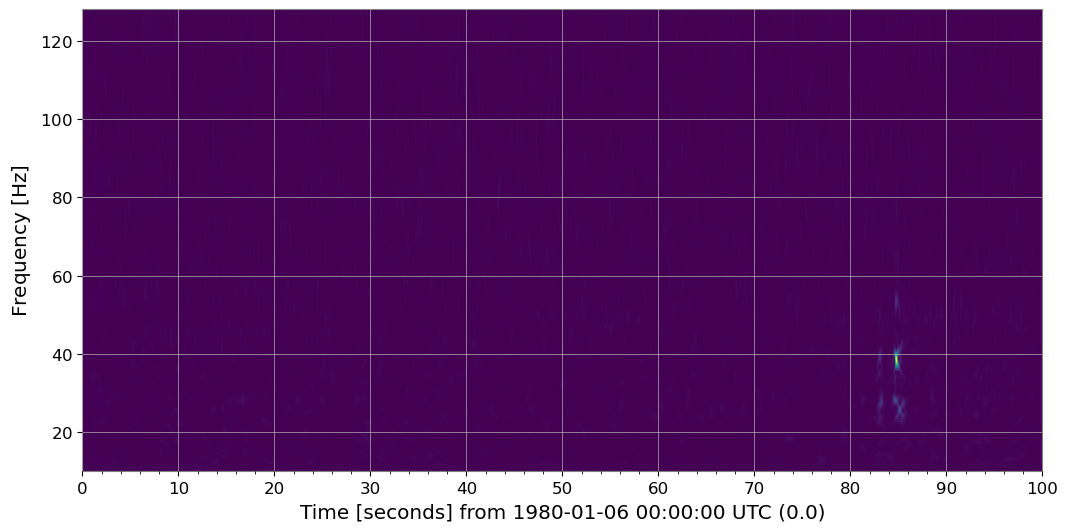

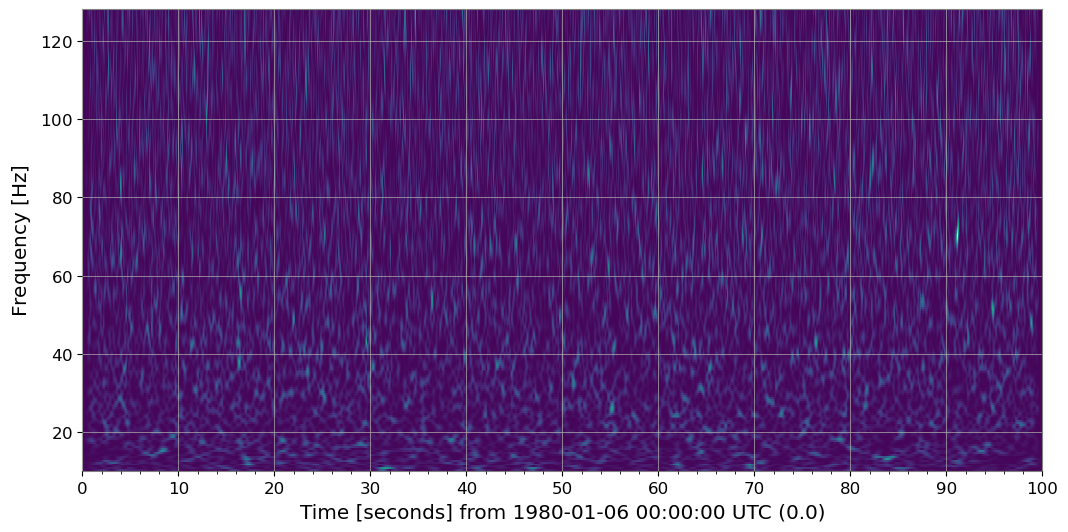

In [60]:
(prova_df.loc[0,'V1:Hrec_hoft_16384Hz']*1000).whiten().q_transform(frange=(10,128)).plot()
(prova_df.iloc[0,35]*100).q_transform(frange=(10,128)).plot()
plt.xlim=(80,90)
plt.show()
#

0.5117809772491455


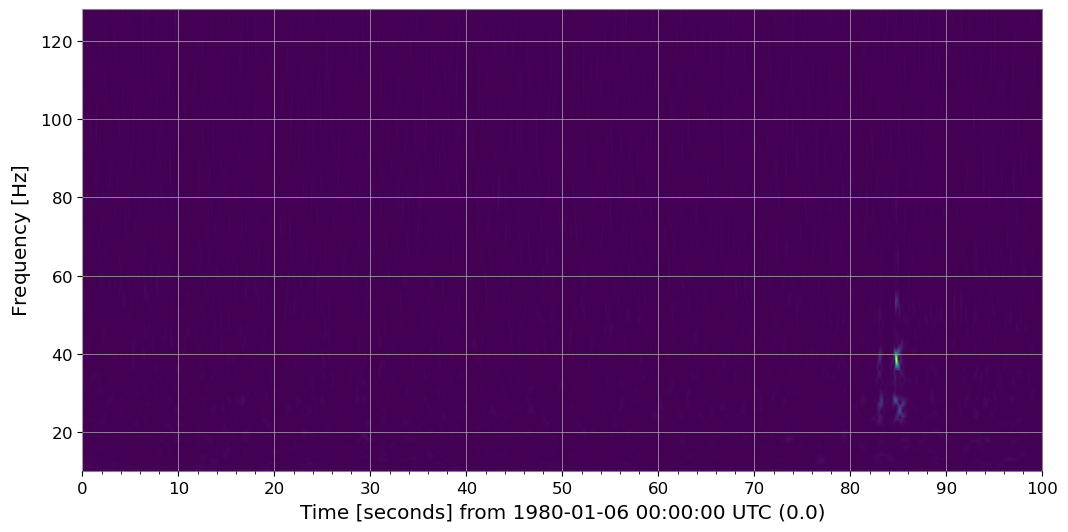

In [51]:
sss=time.time()
time_series=(prova_df.loc[0,'V1:Hrec_hoft_16384Hz'])
max_value = time_series.max()
scaled_data = time_series / max_value
scaled_data.q_transform(frange=(10,128)).plot()
eee=time.time()
print(eee-sss)

-0.855034589767456


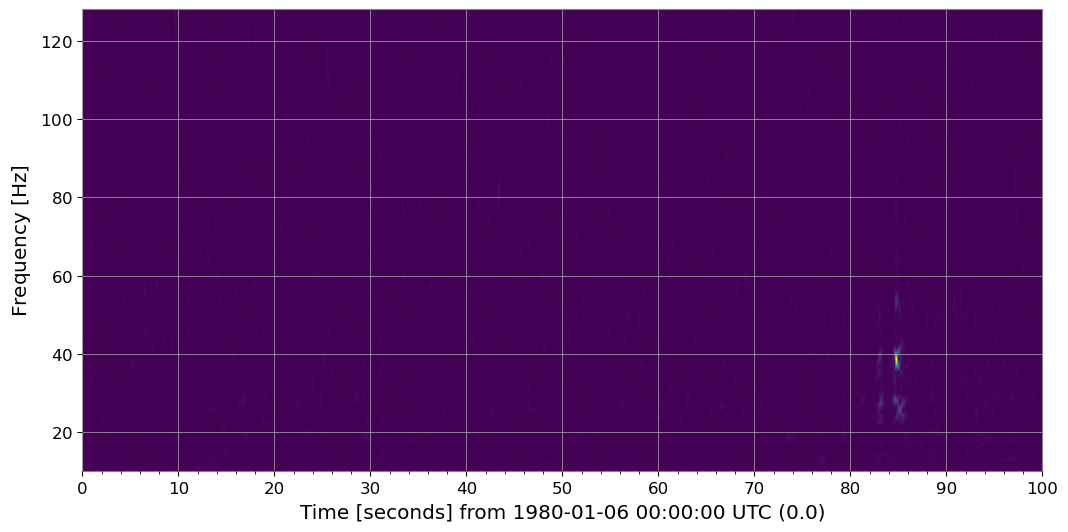

In [52]:
sss=time.time()
time_series=(prova_df.loc[0,'V1:Hrec_hoft_16384Hz'])
scaled_data = time_series *100
scaled_data.q_transform(frange=(10,128)).plot()
eee=time.time()
print(sss-eee)

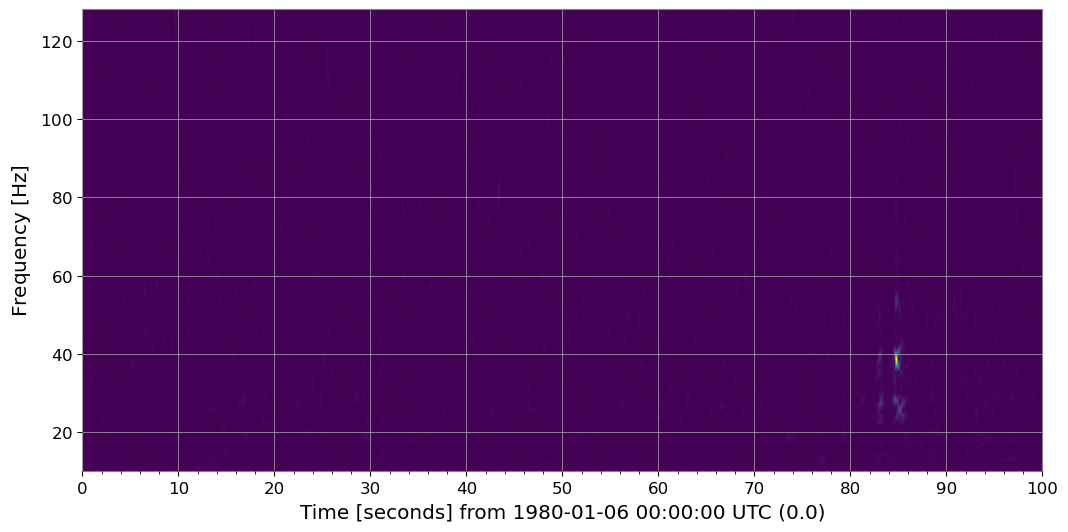

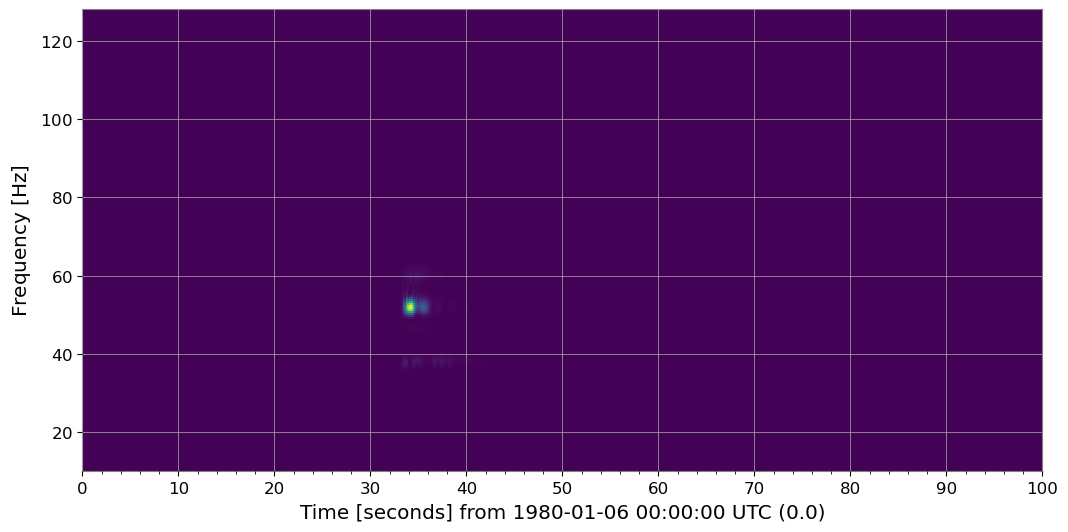

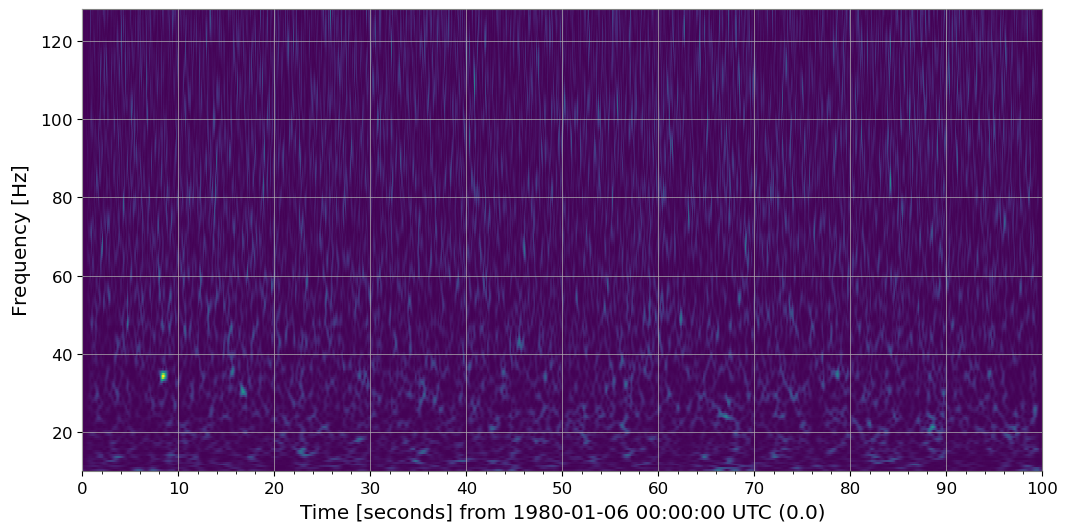

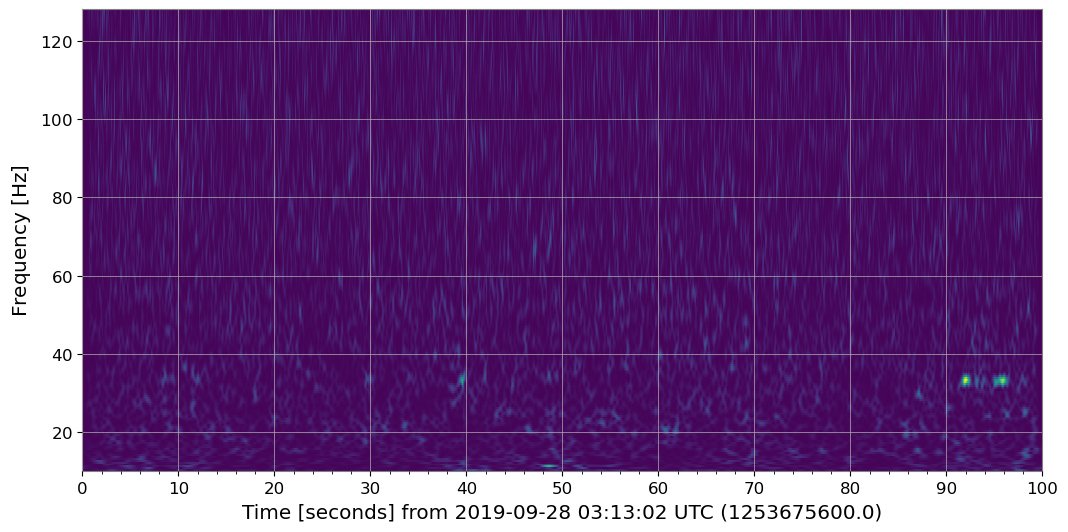

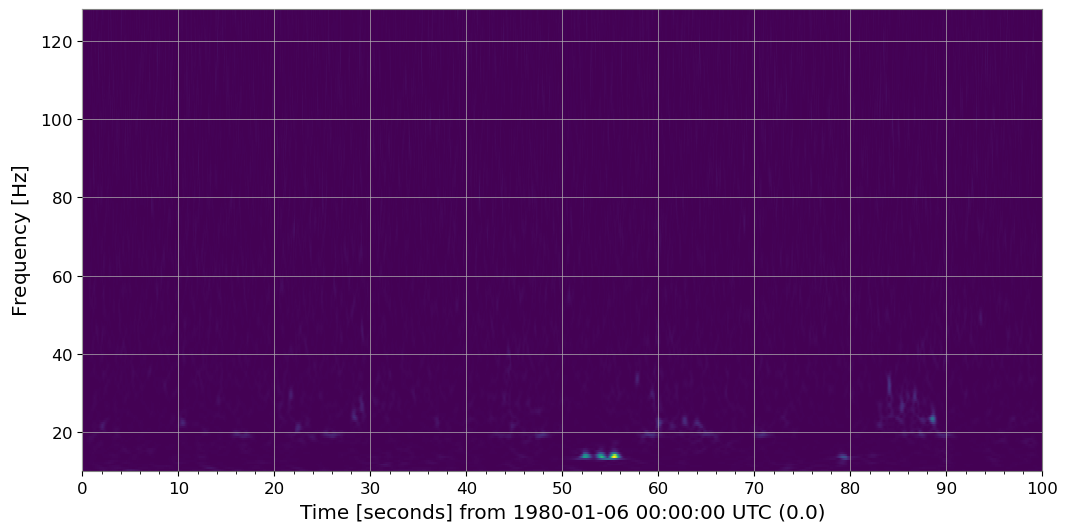

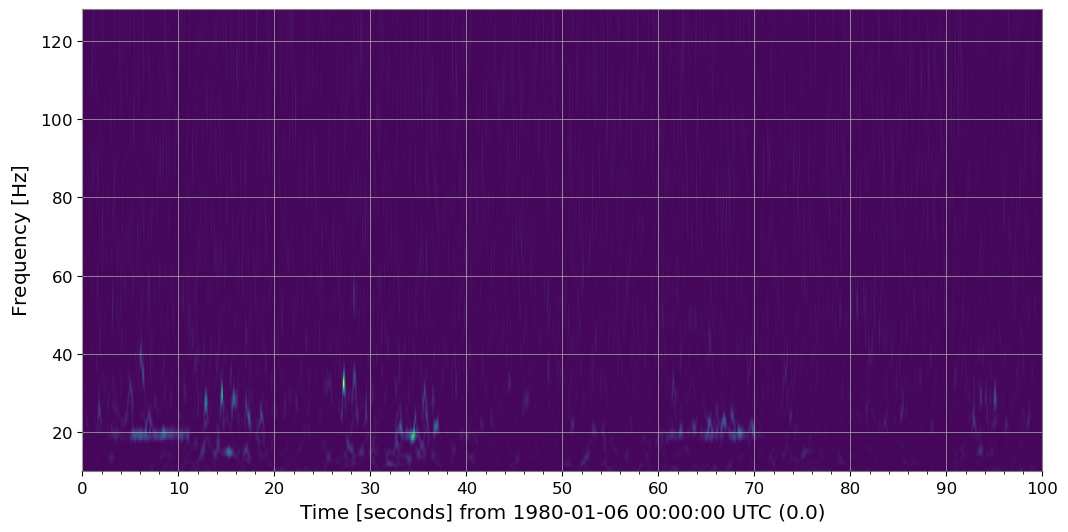

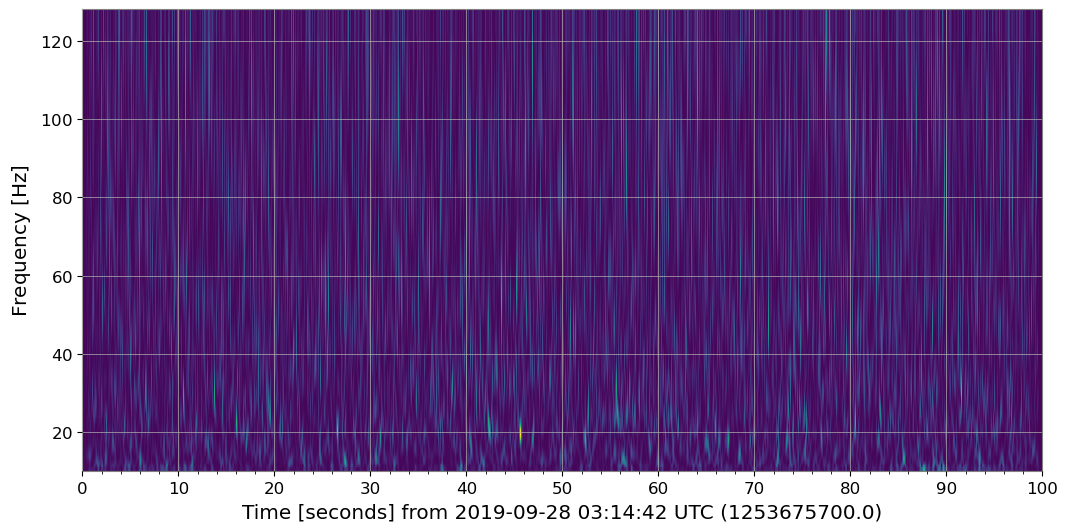

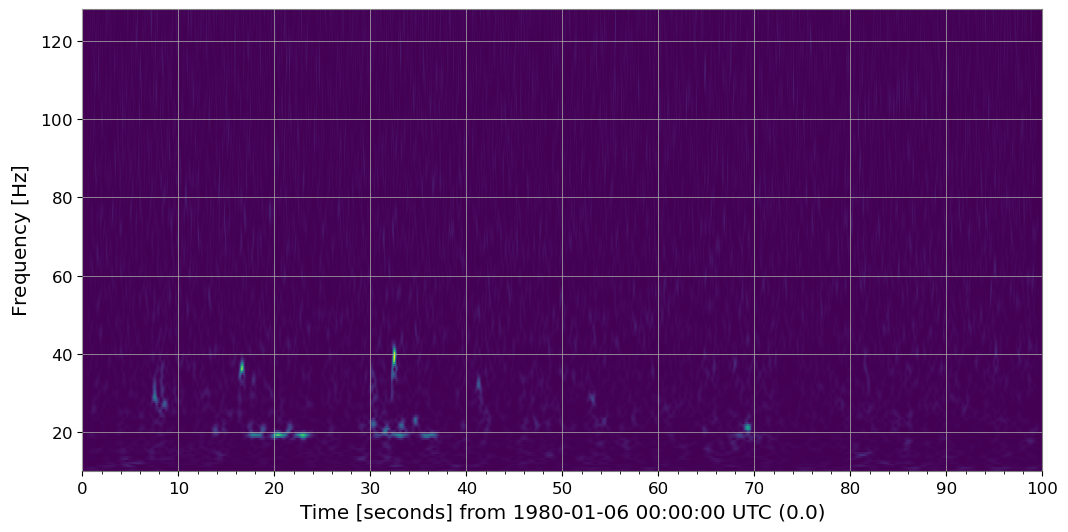

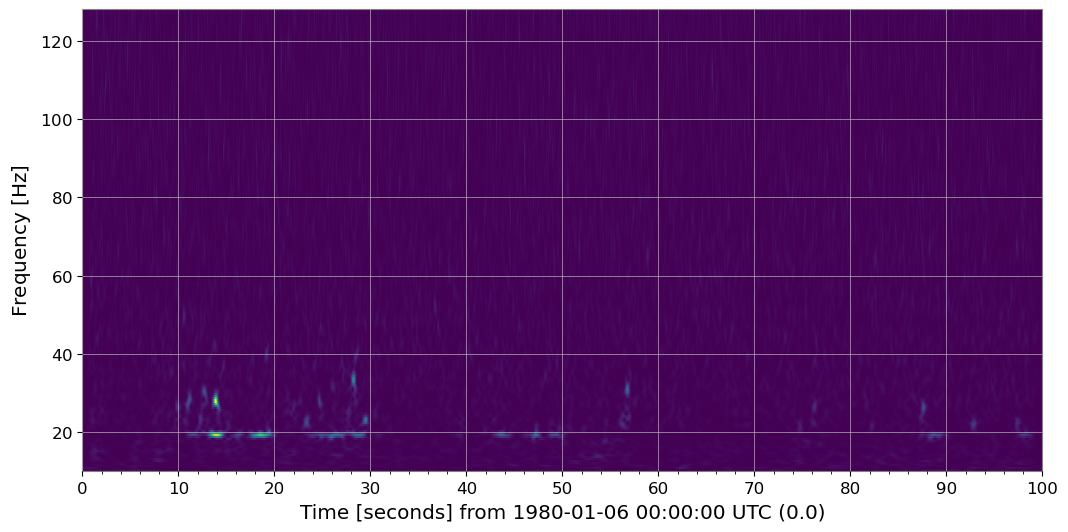

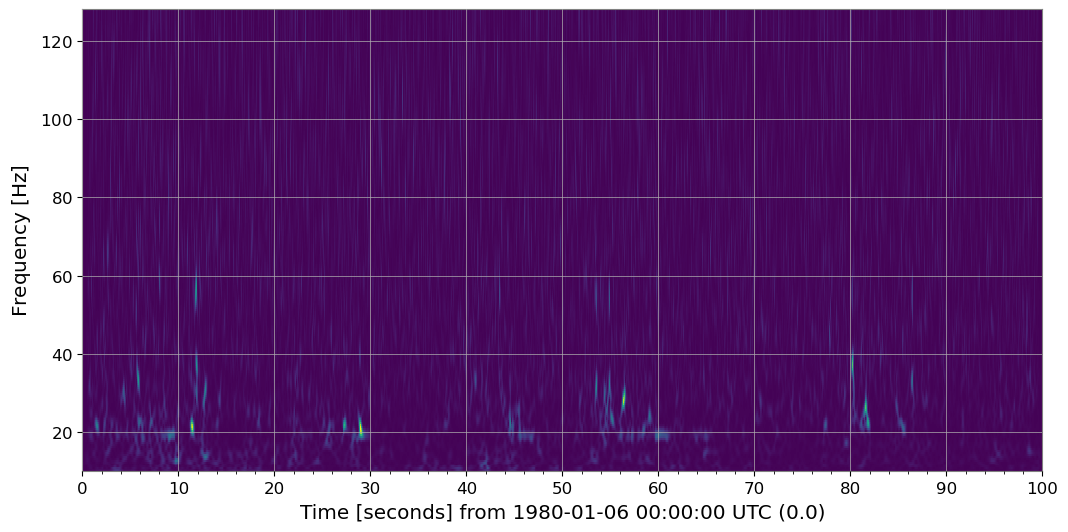

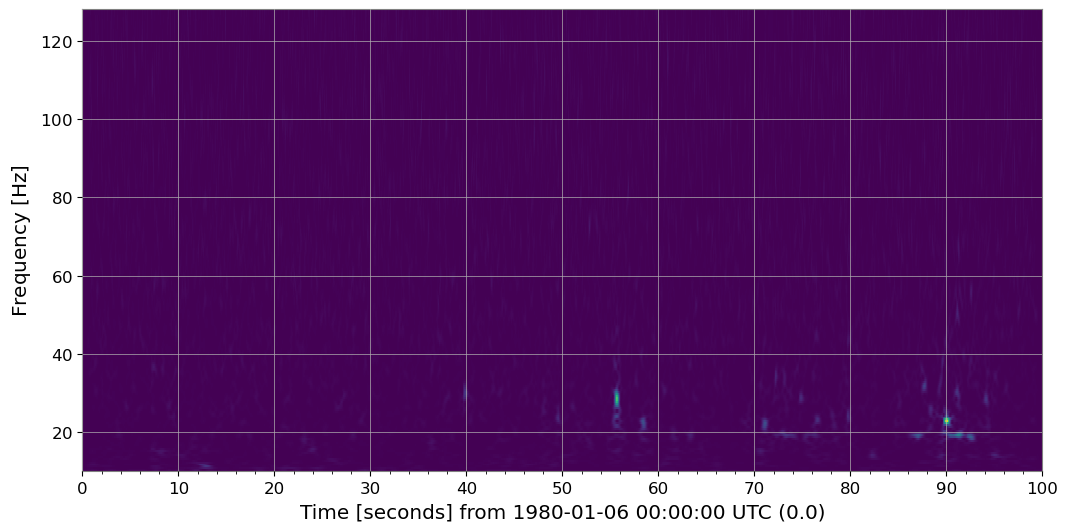

In [27]:
for i in range(11):
    (prova_df.iloc[i,37]*100).q_transform(frange=(10,128)).plot()
plt.show()

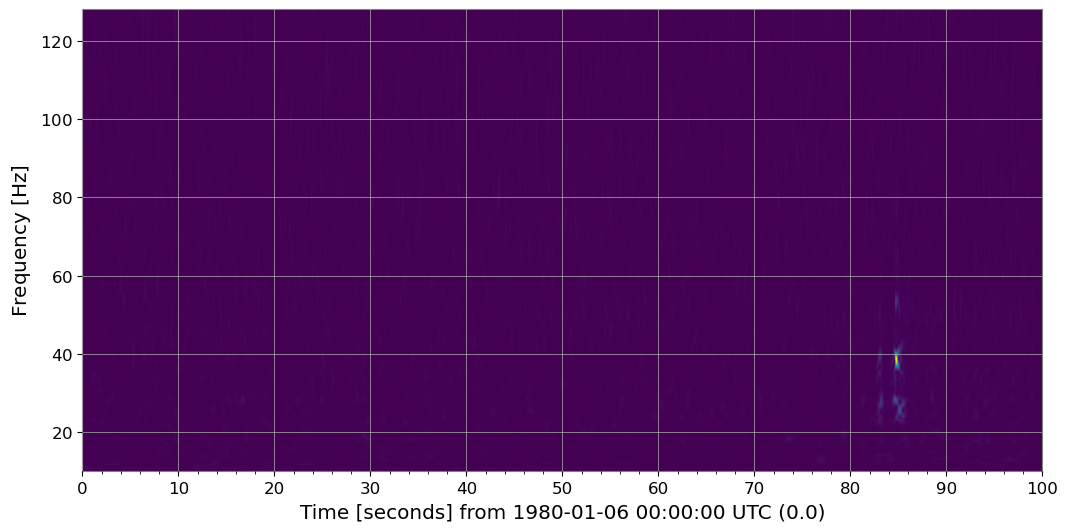

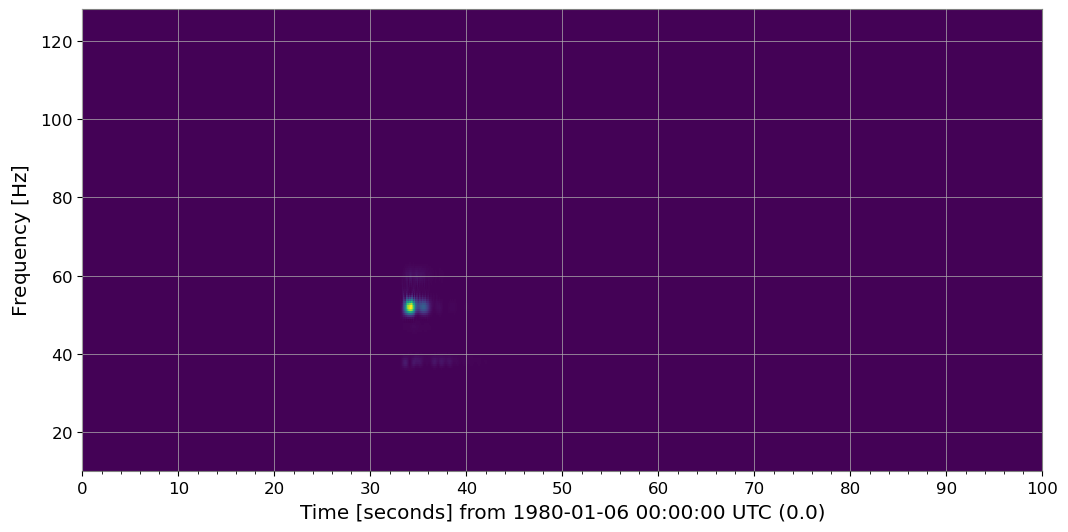

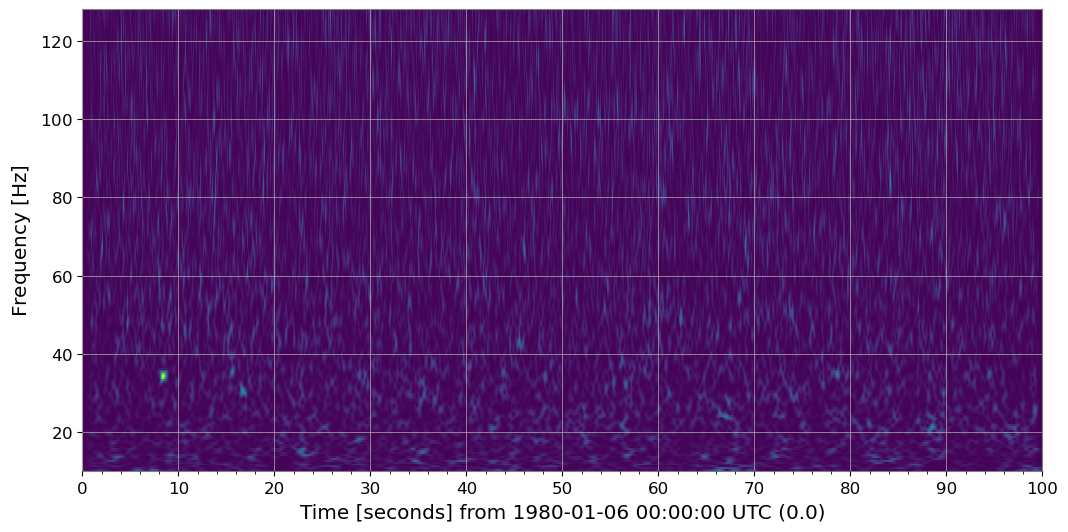

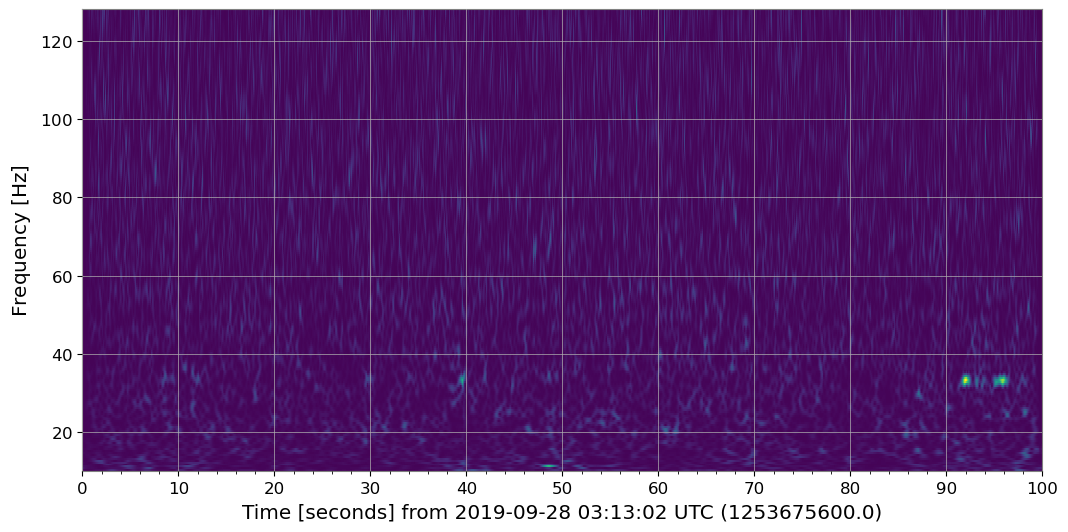

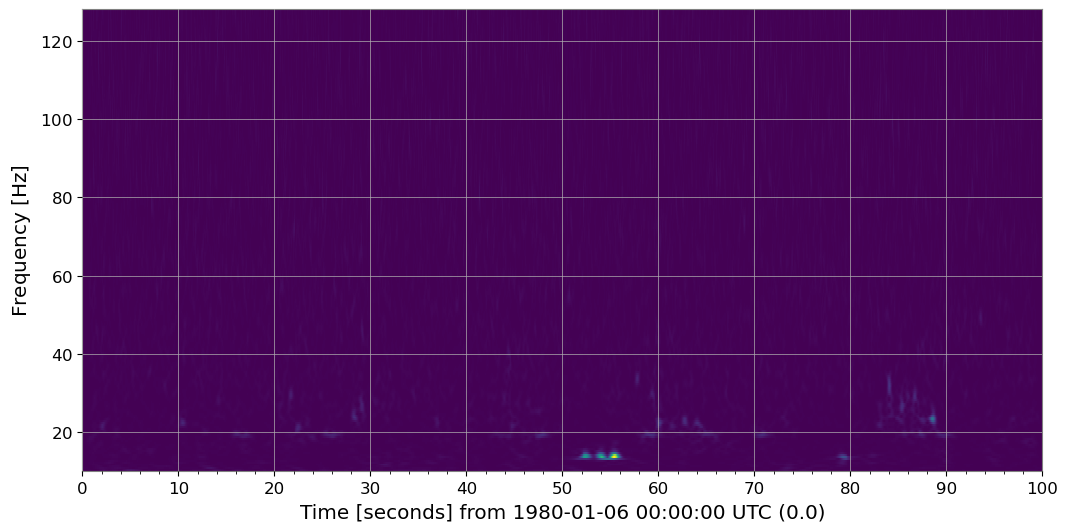

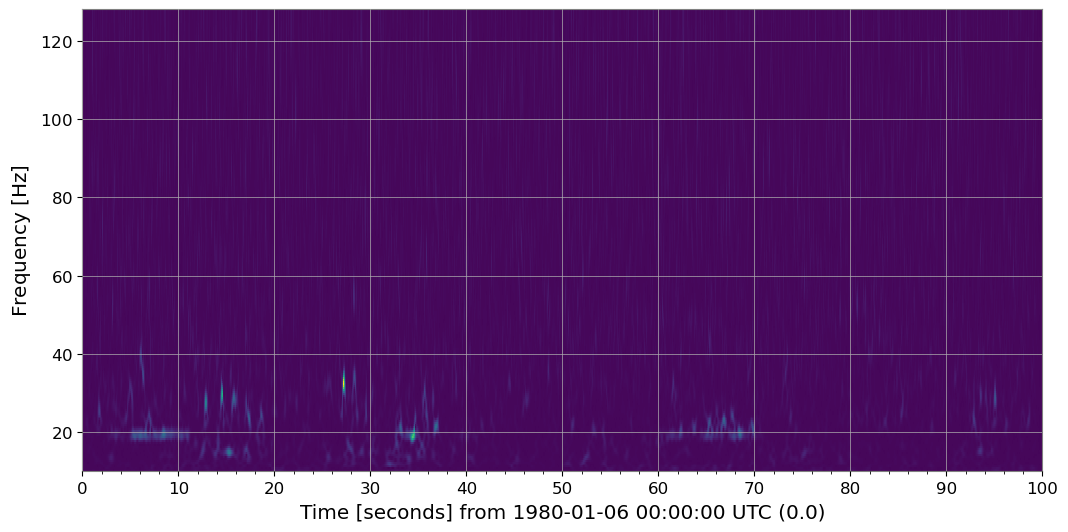

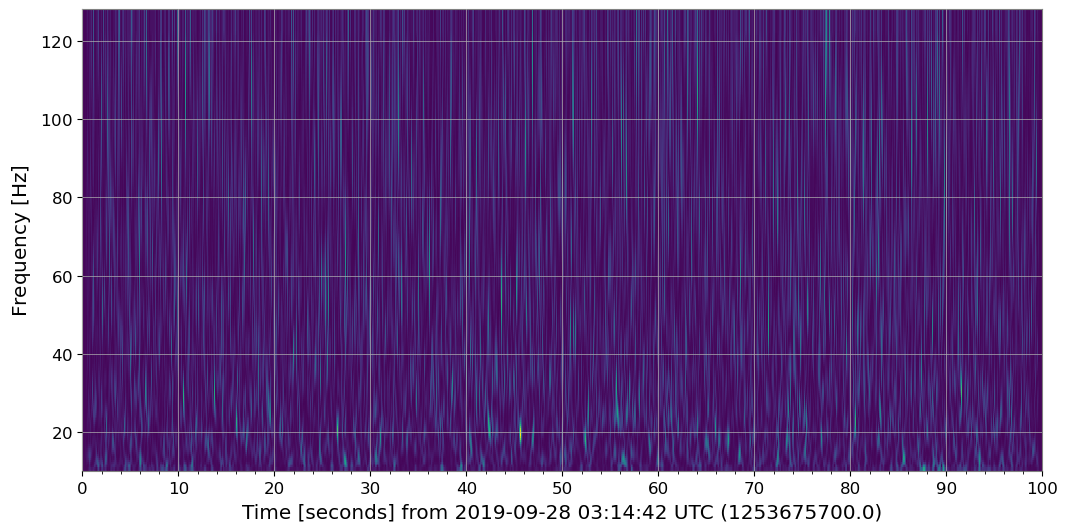

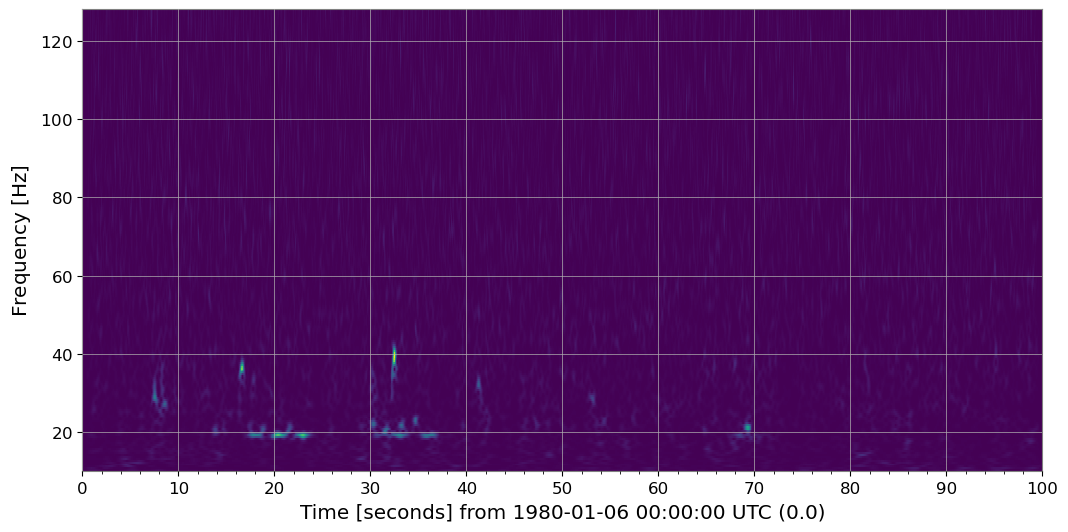

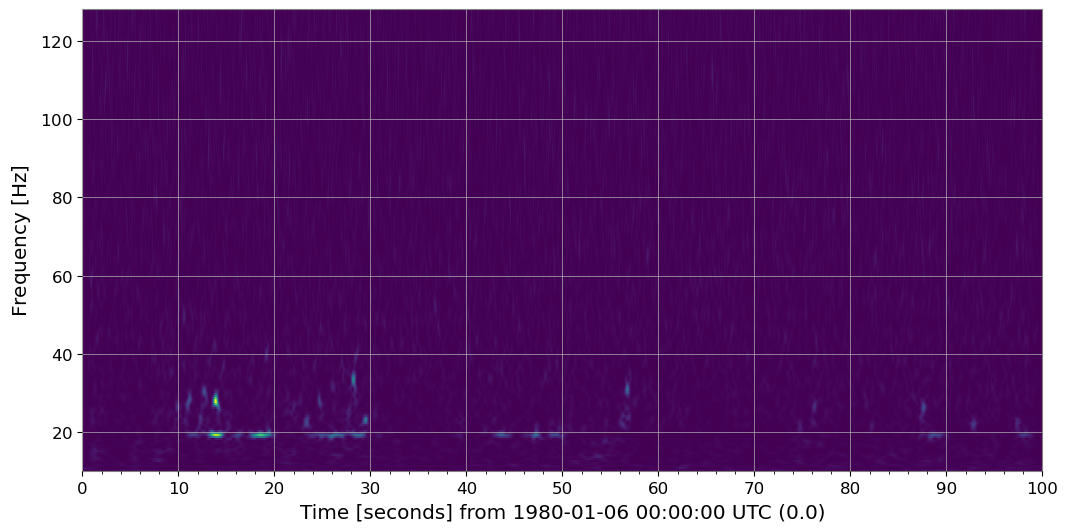

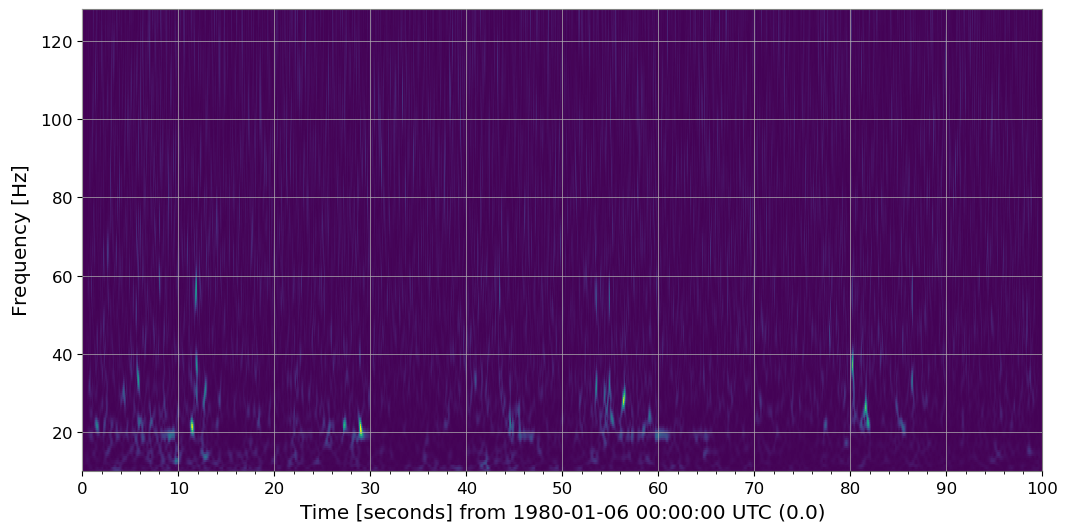

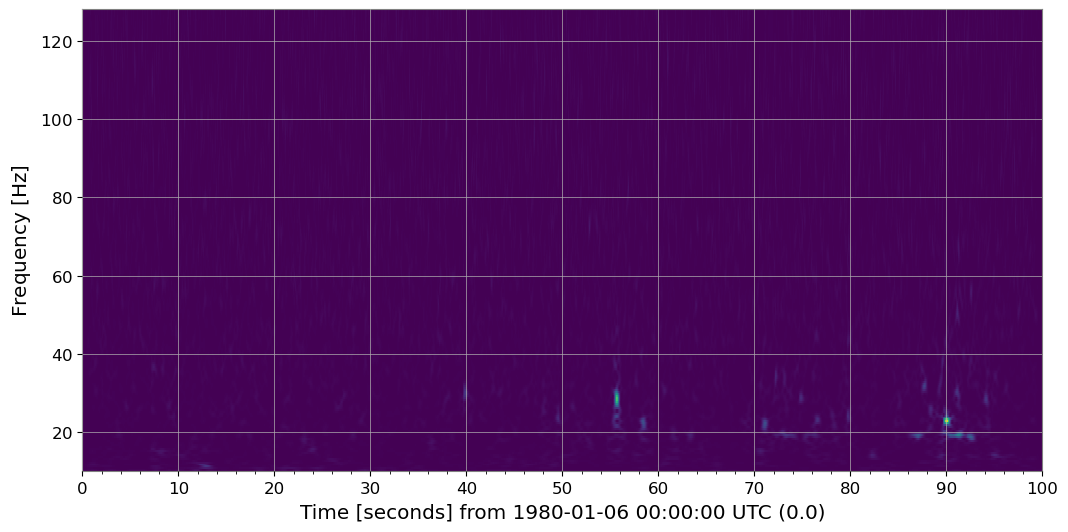

In [30]:
for i in range(11):
    (prova_df.iloc[i,37]*100000).q_transform(frange=(10,128)).plot()
plt.show()

## PICKLE

In [25]:
csv_path='Q-Transforms0_1000.csv'
df_q=pd.read_csv(csv_path)

In [22]:
type(df_q.iloc[0,3])

str

In [16]:
df_torch.to_csv('safe_channels_clean.csv')

In [87]:
path='/data/datasets/intertwin-dati-aux/gspy_O3a_Scattered_Light_V1'
#pickle_rick=construct_dataset(path,save_name='safe channels',channels=['V1:Hrec_hoft_16384Hz','V1:LSC_MICH_ERR','V1:LSC_PRCL_ERR','V1:LSC_PR_CORR'])
pickle_rick=construct_dataset(path,save_name='darm',channels=['V1:LSC_DARM_ERR'])

COULD NOT OPEN /data/datasets/intertwin-dati-aux/gspy_O3a_Scattered_Light_V1/LWrVkYvFcD.h5
Unable to synchronously open file (bad object header version number)
COULD NOT OPEN /data/datasets/intertwin-dati-aux/gspy_O3a_Scattered_Light_V1/Shift_VS_Correlation.png
Unable to synchronously open file (file signature not found)


In [38]:
pickle_rick=pd.read_pickle('safe channels.pkl')
#pickle_rick=pickle_rick[['V1:Hrec_hoft_16384Hz','V1:LSC_MICH_ERR','V1:LSC_PRCL_ERR','V1:LSC_PR_CORR']]

In [41]:
pickle_rick.head(1)

V1:Hrec_hoft_16384Hz  \
0  [tensor(-2.2957e-18, dtype=torch.float64), ten...   

                                     V1:LSC_MICH_ERR  \
0  [tensor(0.5400), tensor(0.7969), tensor(0.7384...   

                                     V1:LSC_PRCL_ERR  \
0  [tensor(2.6768e-05), tensor(1.8553e-05), tenso...   

                                      V1:LSC_PR_CORR  
0  [tensor(4.2447), tensor(7.5534), tensor(6.8048...

In [ ]:
pickle_rick.to_pickle('dataset ')